#**PROJECT OVERVIEW**
---
The aim of this project is to analyze patterns in patient readmission of a hospital, in order to understand the characteristics of patients who risk being readmitted to the hospital. Based on this pattern, the a classification model could be made, which can be used to predict if a patient would be readmitted or not.

https://drive.google.com/file/d/1VGObnoMX-dhwOFnQ03hiT_Y92-9lzhs-/view?usp=drive_link

note: in order to make it easier to extract, it is decided that the data would be placed inside github

#**Importing Libraries**
---

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import RobustScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

#**Data Loading**
---
1. **age** - The patient’s age group (e.g., [70-80) means between 70 and 79 years old).
2. **time_in_hospital** - Number of days the patient stayed in the hospital during the visit.
3. **n_lab_procedures** -	Number of lab tests or lab-related procedures performed.
4. **n_procedures** - Number of non-lab medical procedures performed (e.g., imaging, surgery).
5. **n_medications** - Number of distinct medications prescribed during the hospital stay.
6. **n_outpatient** - Number of outpatient visits (hospital visits without admission) in the past year.
7. **n_inpatient** - Number of inpatient admissions in the past year.
8. **n_emergency** - Number of emergency department visits in the past year.
9. **medical_specialty** - The specialty of the admitting physician or department (e.g., Internal Medicine, Cardiology).
10. **diag_1** - Primary diagnosis (main medical condition treated, e.g., Circulatory, Respiratory, Diabetes).
11. **diag_2** - Secondary diagnosis (an additional or related medical condition).
12. **diag_3** - Tertiary diagnosis (a third related or concurrent condition).
13. **glucose_test** - Indicates whether a glucose serum test was performed (yes or no).
14. **A1Ctest** - Indicates whether an A1C test (for long-term blood sugar) was performed (yes or no).
change	Whether the patient’s diabetes medication regimen changed during the visit (yes or no).
15. **diabetes_med** - Whether the patient was prescribed any diabetes medication (yes or no).
16. **readmitted** - whether the patient was readmitted to the hospital (yes or no).

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/comradeftj/Datsets/refs/heads/main/Hospital_Readmissions_DA.csv')
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


#**Exploratory Data Analysis**
---

##**1. Data Description**
---

###a. Data Type Description

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

###b. Descriptive Statistics

In [ ]:
df.describe(include='all')

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
count,25000,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000,25000,25000,25000,25000,25000,25000,25000,25000
unique,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,8,8,8,3,3,2,2,2
top,[70-80),NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,Circulatory,Other,Other,no,no,no,yes,no
freq,6837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12382,7824,9056,9107,23625,20938,13497,19228,13246
mean,NaN,4.45332,43.24076,1.352360,16.252400,0.366400,0.615960,0.186600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,3.00147,19.81862,1.715179,8.060532,1.195478,1.177951,0.885873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.00000,31.00000,0.000000,11.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,4.00000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,6.00000,57.00000,2.000000,20.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##**2. Duplicate Data Detection**
---

In [ ]:
df.duplicated().sum()

np.int64(0)

##**3. Data Distribution**
---

###a. Numerical Data Distribution

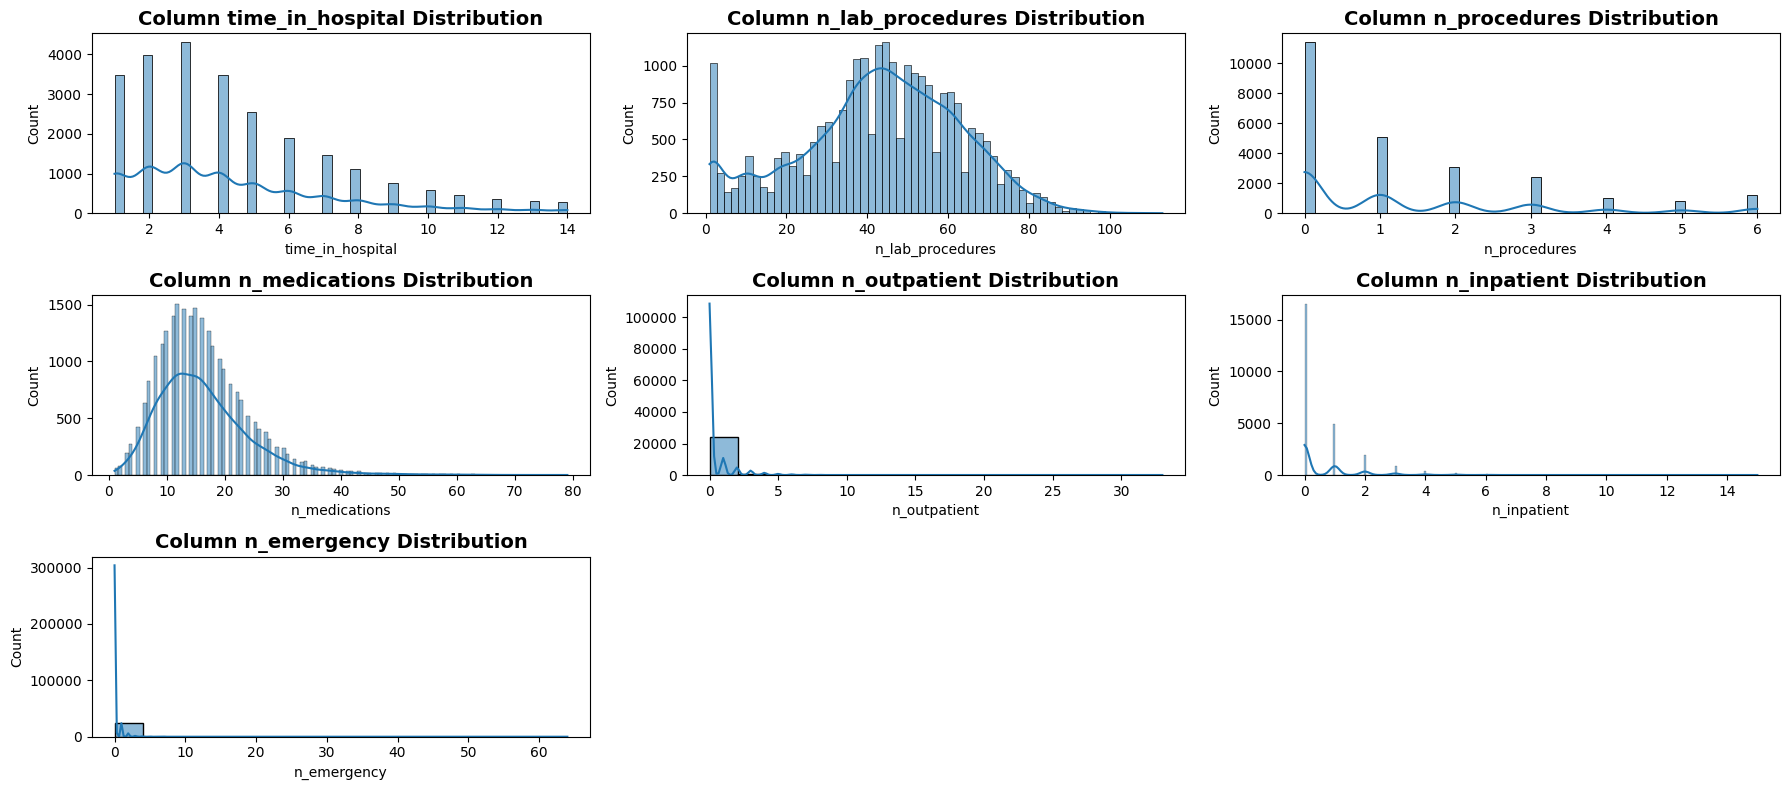

In [ ]:
df_num = df.select_dtypes(include='number')

plt.figure(figsize=(18, 8))
for i, col in enumerate(df_num.columns):
  plt.subplot(3, 3, i+1)
  sns.histplot(df[col], kde=True)
  plt.title(f'Column {col} Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

###b. Categorical Data Distribution
---

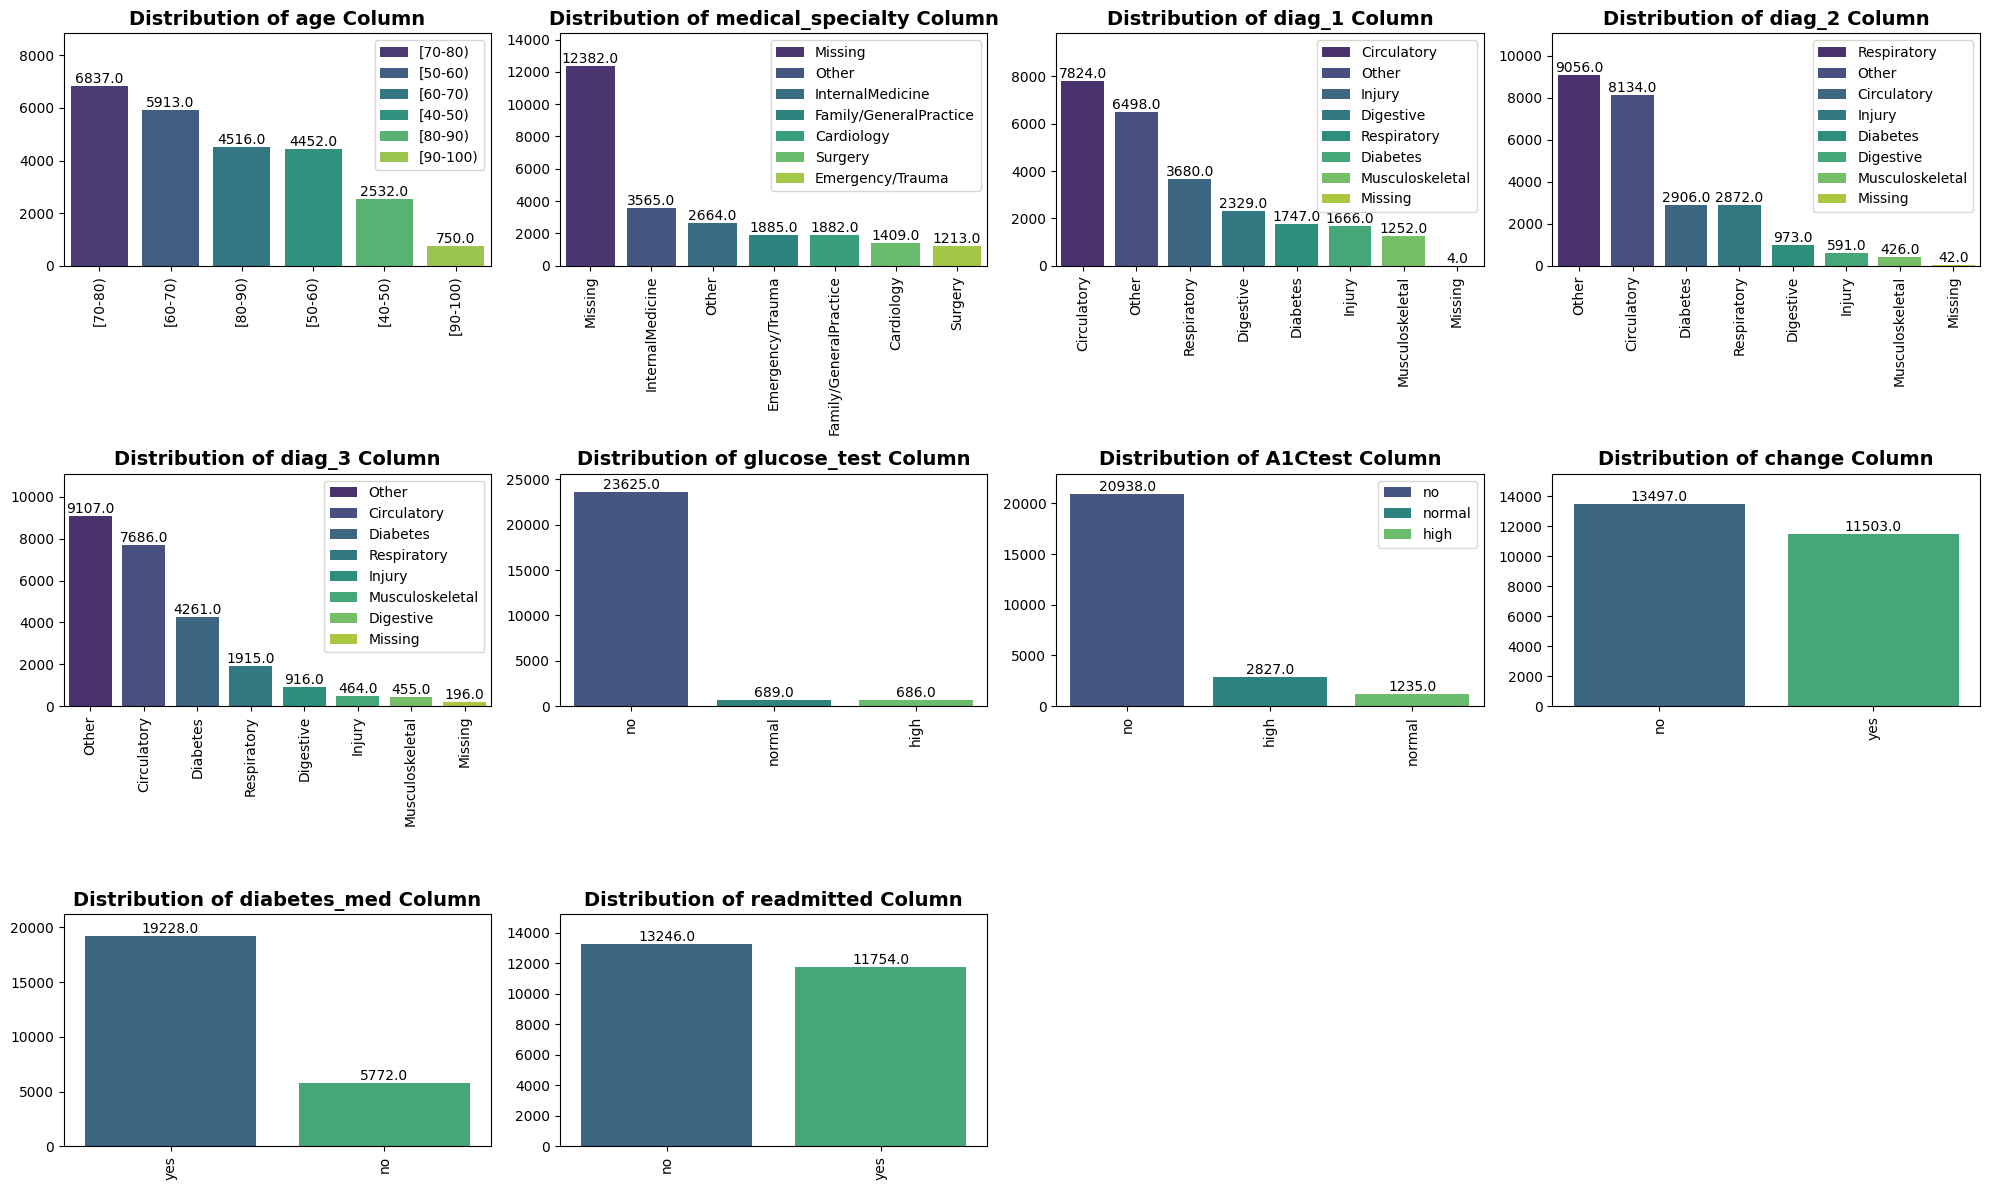

In [ ]:
df_cat = df.select_dtypes(include='object')

plt.figure(figsize=(20, 12))
for i, col in enumerate(df_cat.columns):
  plt.subplot(3, 4, i+1)
  counts = df[col].value_counts()
  ax = sns.barplot(x=counts.index.tolist(), y=counts.values.tolist(), hue=df[col].unique(), palette='viridis')
  for val in ax.containers:
    label=[v.get_height() for v in val]
    ax.bar_label(val, labels=label, label_type='edge')
  plt.title(f'Distribution of {col} Column', fontsize=14, fontweight='bold')
  plt.ylim(ymax=counts.max() + 2000)
  plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##**4. Data Outlier Detection**
---

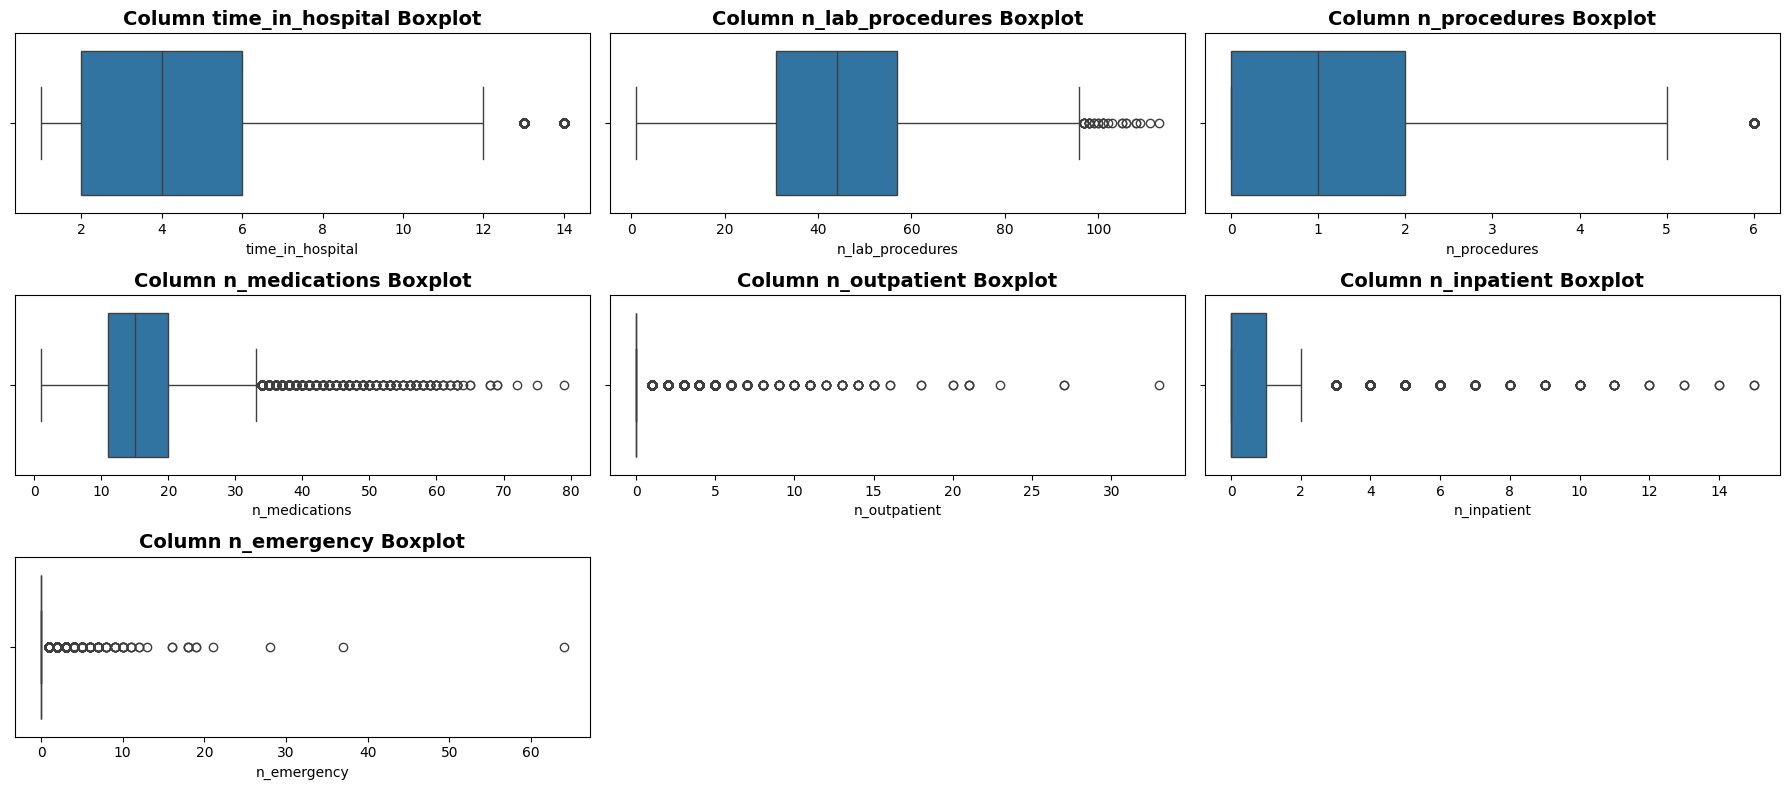

In [ ]:
df_num = df.select_dtypes(include='number')

plt.figure(figsize=(18, 8))
for i, col in enumerate(df_num.columns):
  plt.subplot(3, 3, i+1)
  sns.boxplot(x=df[col])
  plt.title(f'Column {col} Boxplot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

##**5. Data Correlation**
---

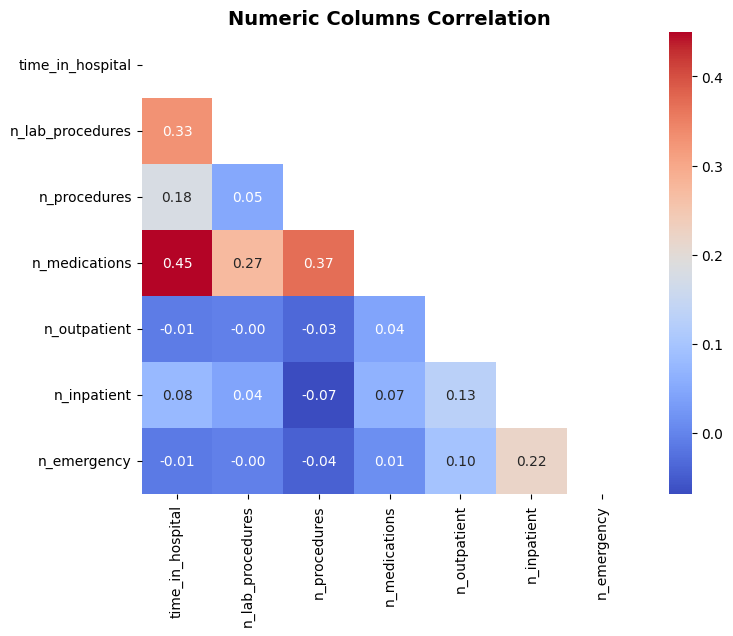

In [ ]:
numeric_corr = df.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(numeric_corr, dtype=float))

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Numeric Columns Correlation', fontsize=14, fontweight='bold')
plt.show()

In [ ]:
'''sns.pairplot(df)
plt.show()'''

'sns.pairplot(df)\nplt.show()'

##**6. Readmitted Patient Characteristics**
---

In [ ]:
df_readmitted = df[df['readmitted'] == 'yes']
df_not_readmitted = df[df['readmitted'] == 'no']

###a. On Readmitted Patients

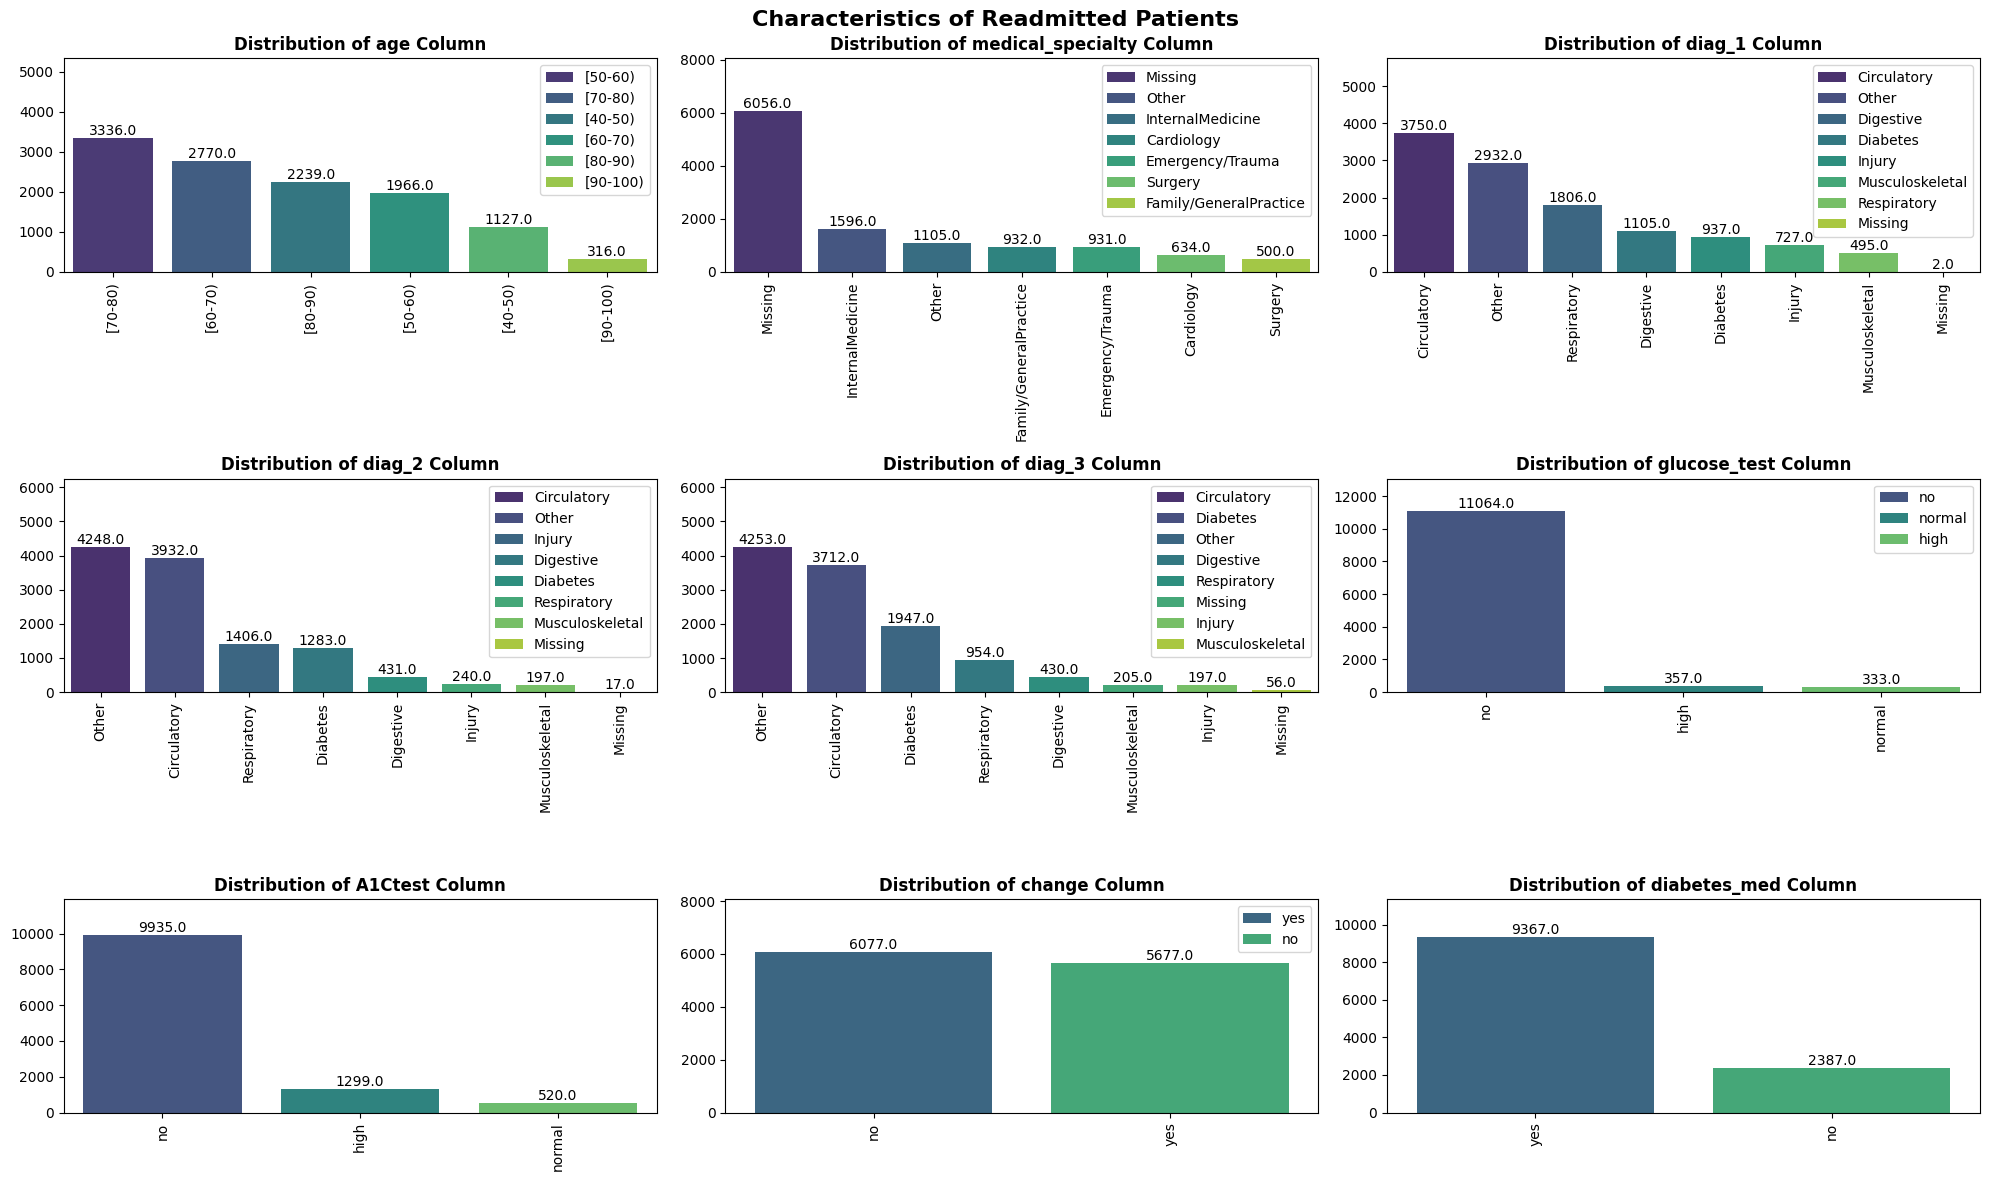

In [ ]:
df_readmitted_cat = df_readmitted.select_dtypes(include='object')

plt.figure(figsize=(20, 12))
for i, col in enumerate(df_readmitted_cat.columns):
  if col == 'readmitted':
    continue
  plt.subplot(3, 3, i+1)
  counts = df_readmitted_cat[col].value_counts()
  ax = sns.barplot(x=counts.index.tolist(), y=counts.values.tolist(), hue=df_readmitted_cat[col].unique(), palette='viridis')
  for val in ax.containers:
    label=[v.get_height() for v in val]
    ax.bar_label(val, labels=label, label_type='edge')
  plt.title(f'Distribution of {col} Column', fontweight='bold', fontsize=12)
  plt.ylim(ymax=counts.max() + 2000)
  plt.xticks(rotation=90)
plt.suptitle('Characteristics of Readmitted Patients', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

###a. On Not Readmitted Patients

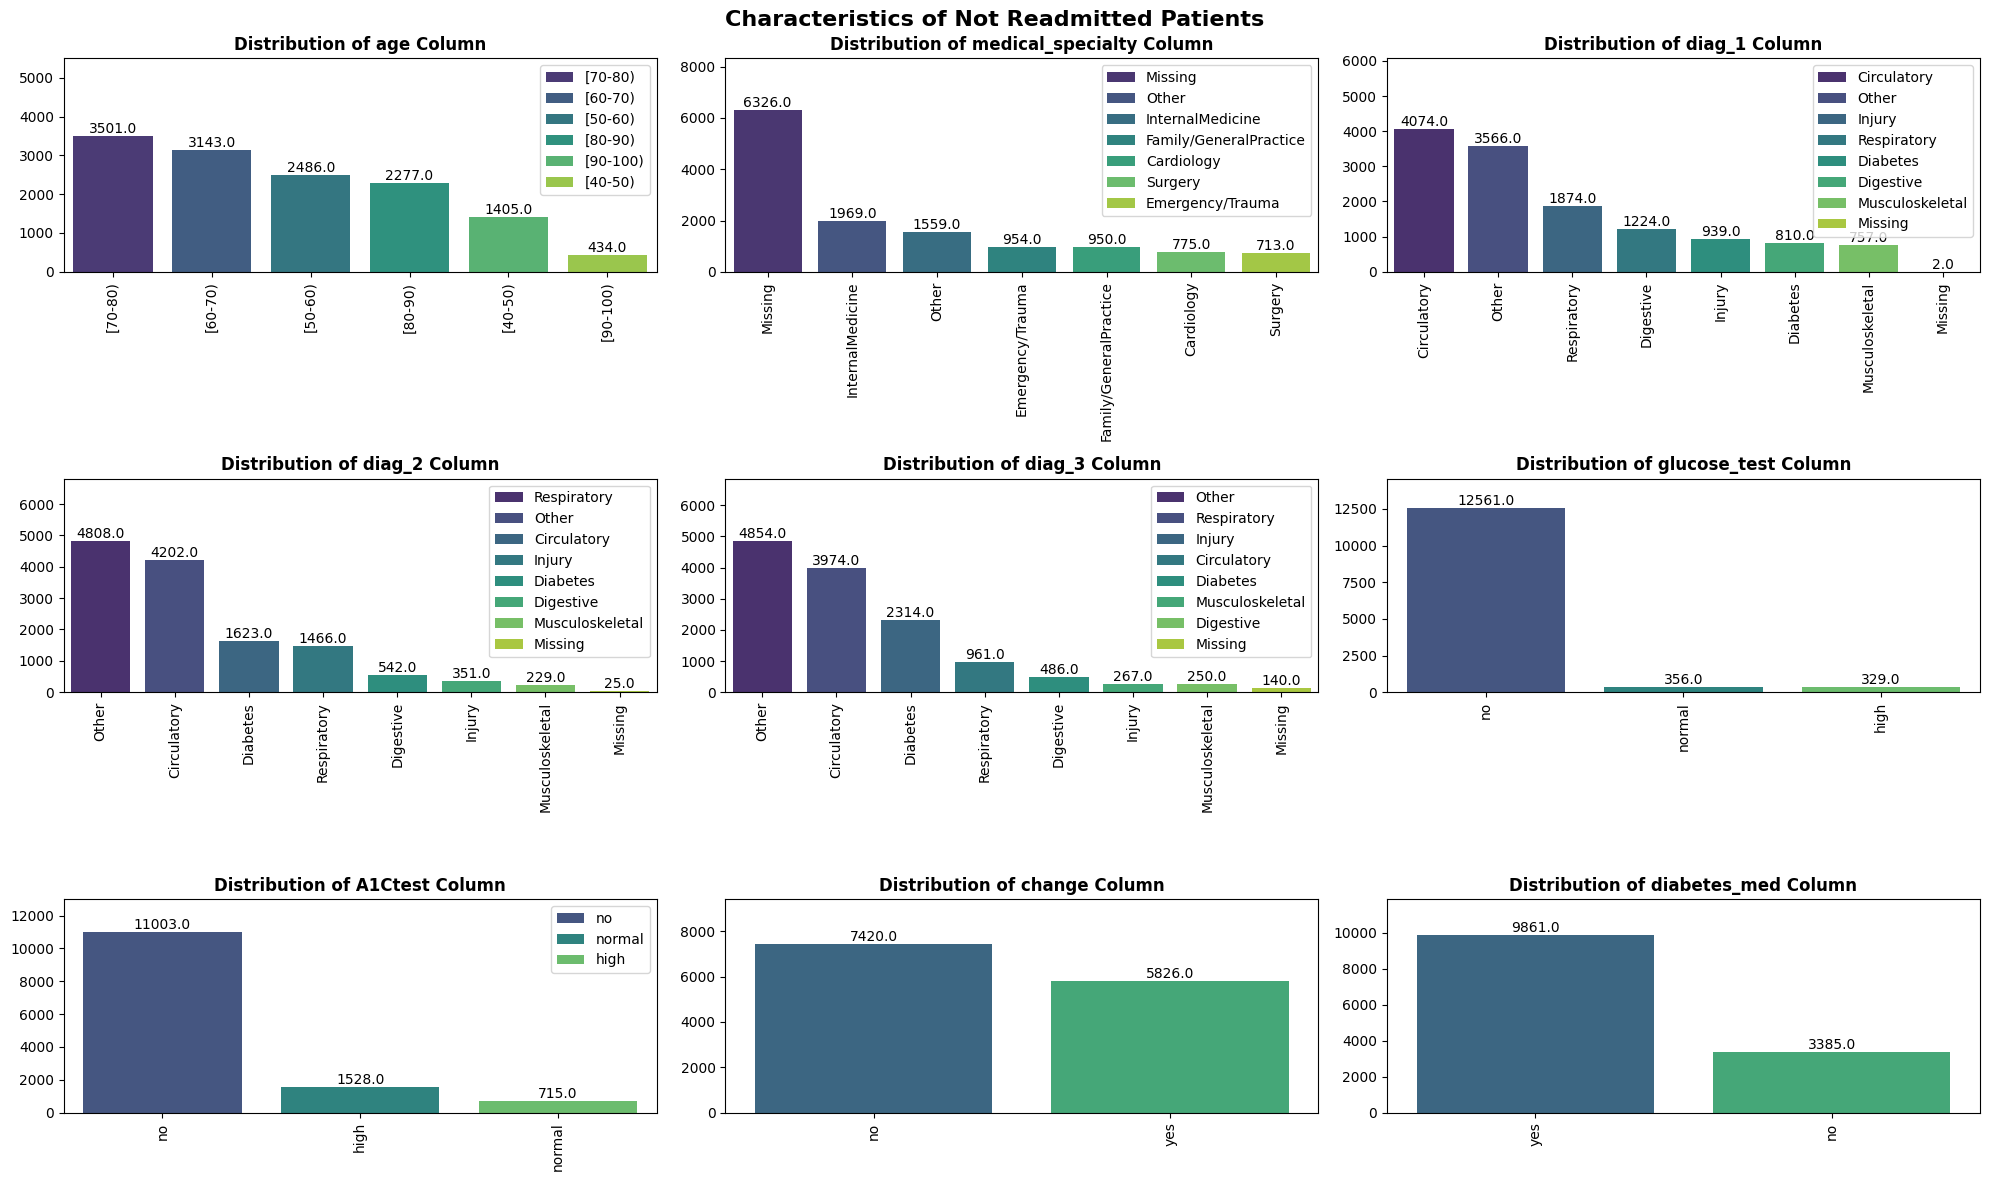

In [ ]:
df_not_readmitted_cat = df_not_readmitted.select_dtypes(include='object')

plt.figure(figsize=(20, 12))
for i, col in enumerate(df_not_readmitted_cat.columns):
  if col == 'readmitted':
    continue
  plt.subplot(3, 3, i+1)
  counts = df_not_readmitted_cat[col].value_counts()
  ax = sns.barplot(x=counts.index.tolist(), y=counts.values.tolist(), hue=df_not_readmitted_cat[col].unique(), palette='viridis')
  for val in ax.containers:
    label=[v.get_height() for v in val]
    ax.bar_label(val, labels=label, label_type='edge')
  plt.title(f'Distribution of {col} Column', fontweight='bold', fontsize=12)
  plt.ylim(ymax=counts.max() + 2000)
  plt.xticks(rotation=90)
plt.suptitle('Characteristics of Not Readmitted Patients', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

#**Data Cleaning**
---

##**1. Missing Values Handling**
---
Whilst there are no missing values (values of NaN), there are columns (categorical columns) which has values classed as 'Missing', which could be found in columns:
1. medical_specialty
2. diag_1
3. diag_2
4. diag_3

In [ ]:
columns = ['medical_specialty', 'diag_1', 'diag_2', 'diag_3']

for col in columns:
  missing = df[df[col] == 'Missing']
  pct_missing = (len(missing)/len(df)) * 100
  print(f'Number of missing values on {col} column: {len(missing)}')
  print(f'Percentage of missing values on {col} column: {pct_missing}%')
  print(' ')

Number of missing values on medical_specialty column: 12382
Percentage of missing values on medical_specialty column: 49.528%
 
Number of missing values on diag_1 column: 4
Percentage of missing values on diag_1 column: 0.016%
 
Number of missing values on diag_2 column: 42
Percentage of missing values on diag_2 column: 0.168%
 
Number of missing values on diag_3 column: 196
Percentage of missing values on diag_3 column: 0.784%
 


Based on this, the column 'medical_specialty' would not be used, as it has almost 50% missing values, which is much to high.

As for the other columns, the missing values would be replaced with the mode of their respective columns (since the missing values are <1%, and thus won't affect the data much)

In [ ]:
df = df.drop(columns='medical_specialty')

In [ ]:
columns = ['diag_1', 'diag_2', 'diag_3']

for col in columns:
  df_with_missing = np.where(df[col] == 'Missing')[0]
  df.loc[df_with_missing, col] = df[col].mode()[0]

df.head(3)

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes


##**2. Outlier Handling**
---
In this step, the outliers are replaced with mean or median, as whilst their numbers are low (as such, not going to affect the results hevaily), the outliers are still fairly significant and prevalent (comprising of up to 16.5% of a column)

In [ ]:
df_num = df.select_dtypes(include='number')
data_outliers = {}

for col in df_num.columns:
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3-q1
  outliers = np.where((df[col] < q1 - iqr * 1.5) | (df[col] > q3 + iqr * 1.5))[0]
  pct_outlier = (len(outliers) / len(df)) * 100
  data_outliers[col] = df.loc[outliers, :]

  print(f'Number of outliers on {col} column: {len(outliers)}')
  print(f'Percentage of outliers on {col} column: {pct_outlier}%')
  print(' ')

Number of outliers on time_in_hospital column: 580
Percentage of outliers on time_in_hospital column: 2.32%
 
Number of outliers on n_lab_procedures column: 33
Percentage of outliers on n_lab_procedures column: 0.132%
 
Number of outliers on n_procedures column: 1227
Percentage of outliers on n_procedures column: 4.9079999999999995%
 
Number of outliers on n_medications column: 844
Percentage of outliers on n_medications column: 3.376%
 
Number of outliers on n_outpatient column: 4141
Percentage of outliers on n_outpatient column: 16.564%
 
Number of outliers on n_inpatient column: 1628
Percentage of outliers on n_inpatient column: 6.512%
 
Number of outliers on n_emergency column: 2728
Percentage of outliers on n_emergency column: 10.911999999999999%
 


In [ ]:
for val in data_outliers:
  print(f'Column {val} Outliers:')
  display(data_outliers[val][val])
  print('\n\n')

Column time_in_hospital Outliers:


,time_in_hospital
136,14
211,13
271,14
284,14
306,13
...,...
24726,14
24860,14
24926,13
24971,13





Column n_lab_procedures Outliers:


,n_lab_procedures
150,102
675,108
878,101
968,97
1120,100
2676,98
2868,98
2948,101
3909,99
3980,103





Column n_procedures Outliers:


,n_procedures
7,6
33,6
35,6
47,6
63,6
...,...
24878,6
24903,6
24950,6
24967,6





Column n_medications Outliers:


,n_medications
104,39
134,34
136,40
208,38
211,38
...,...
24750,52
24868,42
24932,38
24968,49





Column n_outpatient Outliers:


,n_outpatient
0,2
3,1
25,1
30,2
39,2
...,...
24954,2
24966,1
24967,4
24969,1





Column n_inpatient Outliers:


,n_inpatient
25,3
37,6
45,9
49,3
50,7
...,...
24915,3
24943,10
24946,3
24953,4





Column n_emergency Outliers:


,n_emergency
7,1
31,1
37,10
50,1
59,1
...,...
24954,2
24966,3
24969,1
24975,2


As the number of outliers are relatively low when compared to the rest of the data, combined with the fact that the outliers are valid observations, it is decided that the outliers would not be handled. Another reason for this decision is the relatively worse performance that was experienced when these outliers are handled.

In [ ]:
'''df_num = df.select_dtypes(include='number')

for col in df_num.columns:
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3-q1
  outliers = np.where((df[col] < q1 - iqr * 1.5) | (df[col] > q3 + iqr * 1.5))[0]
  if col == 'n_lab_procedures':
    df.loc[outliers, col] = df[col].mean()
  else:
    df.loc[outliers, col] = df[col].median()

plt.figure(figsize=(18, 8))
for i, col in enumerate(df_num.columns):
  plt.subplot(3, 3, i+1)
  sns.boxplot(x=df[col])
  plt.title(f'Column {col} Boxplot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()'''

"df_num = df.select_dtypes(include='number')\n\nfor col in df_num.columns:\n  q1 = df[col].quantile(0.25)\n  q3 = df[col].quantile(0.75)\n  iqr = q3-q1\n  outliers = np.where((df[col] < q1 - iqr * 1.5) | (df[col] > q3 + iqr * 1.5))[0]\n  if col == 'n_lab_procedures':\n    df.loc[outliers, col] = df[col].mean()\n  else:\n    df.loc[outliers, col] = df[col].median()\n\nplt.figure(figsize=(18, 8))\nfor i, col in enumerate(df_num.columns):\n  plt.subplot(3, 3, i+1)\n  sns.boxplot(x=df[col])\n  plt.title(f'Column {col} Boxplot', fontsize=14, fontweight='bold')\nplt.tight_layout()\nplt.show()"

#**Data Preparation**
---

##**1. Data Encoding**
---

In [ ]:
label_encode = ['age', 'readmitted', 'diabetes_med', 'change']
one_hot_encode = ['diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest']

###a. One-Hot Encoding

In [ ]:
df_new = df.copy()

In [ ]:
df_new = pd.get_dummies(df, columns=one_hot_encode, drop_first=True, dtype=int)
df_new.head(3)

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,change,diabetes_med,...,diag_3_Diabetes,diag_3_Digestive,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,glucose_test_no,glucose_test_normal,A1Ctest_no,A1Ctest_normal
0,[70-80),8,72,1,18,2,0,0,no,yes,...,0,0,0,0,1,0,1,0,1,0
1,[70-80),3,34,2,13,0,0,0,no,yes,...,0,0,0,0,1,0,1,0,1,0
2,[50-60),5,45,0,18,0,0,0,yes,yes,...,0,0,0,0,0,0,1,0,1,0


###b. Label Encoding

In [ ]:
def apply_encode_age(data):
  if data == '[40-50)':
    return 0
  elif data == '[50-60)':
    return 1
  elif data == '[60-70)':
    return 2
  elif data == '[70-80)':
    return 3
  elif data == '[80-90)':
    return 4
  elif data == '[90-100)':
    return 5

def apply_encode_yesno(data):
  if data == 'yes':
    return 1
  elif data == 'no':
    return 0

df_new['age'] = df_new['age'].apply(apply_encode_age)
for col in ['readmitted', 'diabetes_med', 'change']:
  df_new[col] = df_new[col].apply(apply_encode_yesno)

df_new.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,change,diabetes_med,...,diag_3_Diabetes,diag_3_Digestive,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory,glucose_test_no,glucose_test_normal,A1Ctest_no,A1Ctest_normal
0,3,8,72,1,18,2,0,0,0,1,...,0,0,0,0,1,0,1,0,1,0
1,3,3,34,2,13,0,0,0,0,1,...,0,0,0,0,1,0,1,0,1,0
2,1,5,45,0,18,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
3,3,2,36,0,12,1,0,0,1,1,...,1,0,0,0,0,0,1,0,1,0
4,2,1,42,0,7,0,0,0,0,1,...,0,0,0,0,0,1,1,0,1,0


###c. New Correlations

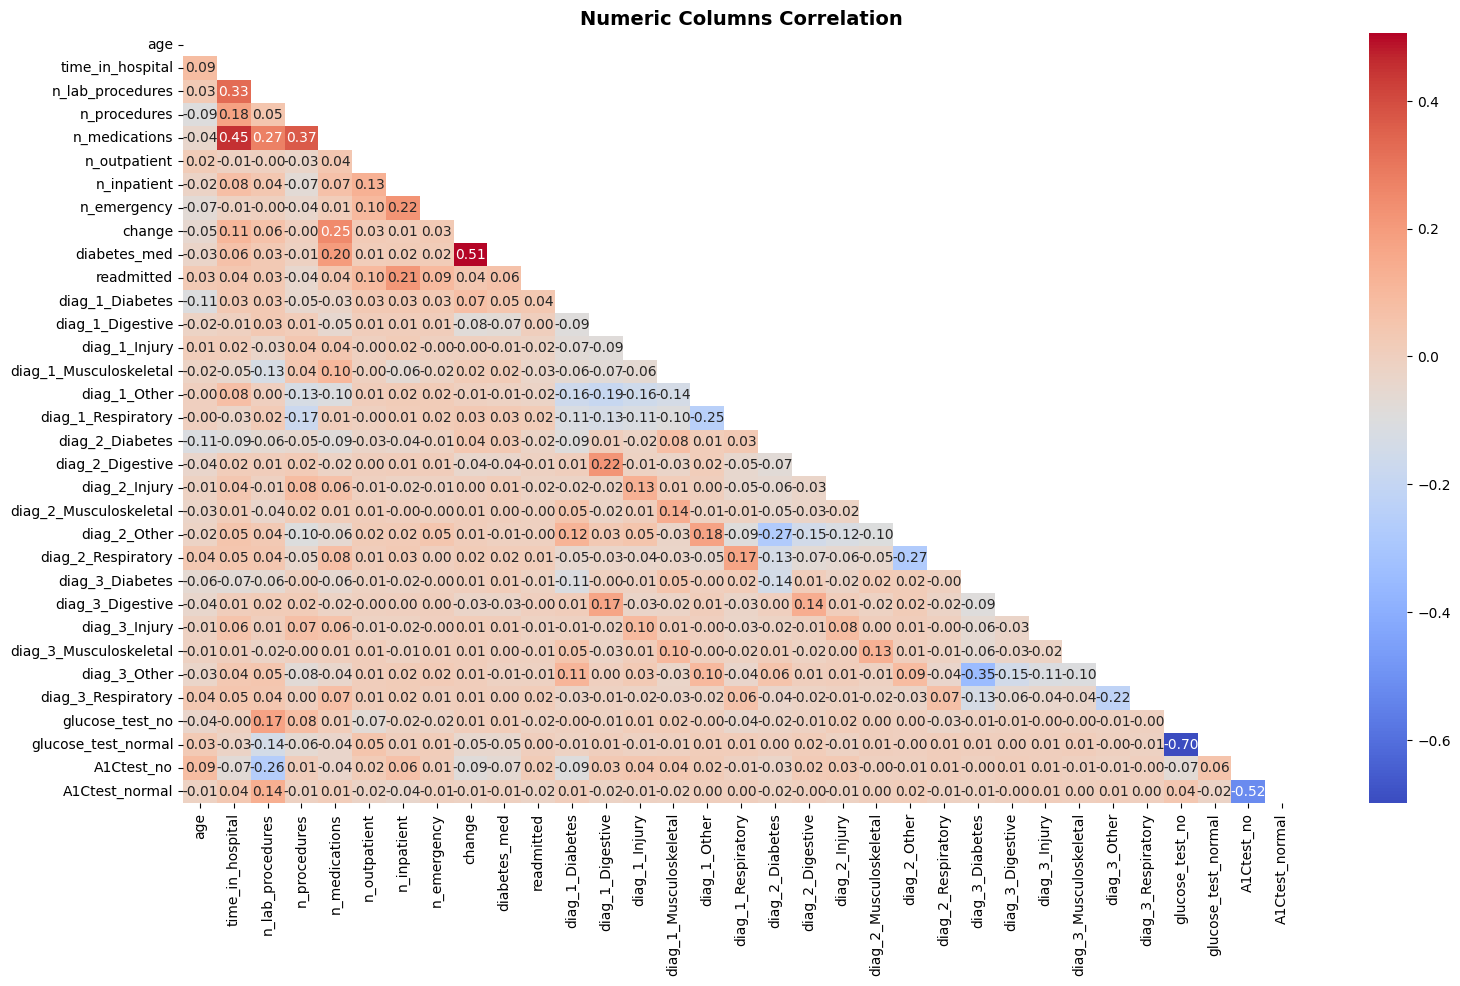

In [ ]:
numeric_corr = df_new.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(numeric_corr, dtype=float))

plt.figure(figsize=(18, 10))
sns.heatmap(numeric_corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Numeric Columns Correlation', fontsize=14, fontweight='bold')
plt.show()

##**2. Feature Selection**
---

In [ ]:
x_input = df_new[[col for col in df_new.columns if col != 'readmitted']]
y = df_new['readmitted']

###a. Select K-Best

In [ ]:
selector_kbest = SelectKBest(score_func=chi2, k=5)
selector_kbest.fit(x_input, y)

score_df = pd.DataFrame({
    'score': selector_kbest.scores_
}, index=x_input.columns.tolist()).sort_values(by='score', ascending=False)
score_df

,score
n_inpatient,2542.510429
n_emergency,919.496308
n_outpatient,889.074252
n_lab_procedures,246.843976
n_medications,135.862482
n_procedures,107.528137
time_in_hospital,94.122749
diag_1_Diabetes,30.722838
diag_1_Musculoskeletal,28.114543
change,25.205415


In [ ]:
cols_skbest = score_df.head(3).index.tolist()

###b. RFECV - Recursive Feature Elimination with Cross-Validation

In [ ]:
lr = LogisticRegression()

selector_rfecv = RFECV(
    estimator=lr,
    step=1,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=5,
    #min_features_to_select=
)
selector_rfecv.fit(x_input, y)

df_to_use = pd.DataFrame({
    'use': selector_rfecv.support_
}, index=x_input.columns.tolist())
display(df_to_use)

Fitting estimator with 32 features.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 31 features.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


,use
age,True
time_in_hospital,False
n_lab_procedures,False
n_procedures,True
n_medications,False
n_outpatient,True
n_inpatient,True
n_emergency,True
change,True
diabetes_med,True


In [ ]:
cols_rfecv = df_to_use[df_to_use['use'] == True].index.tolist()

##**3. Data Splitting**
---

In [ ]:
x = df_new[cols_skbest] #cols_rfecv, cols_skbest
y = df_new['readmitted']

sampler = RandomUnderSampler(random_state=42)
x_resampled, y_resampled = sampler.fit_resample(x, y)

x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=42)

##**4. Data Scaling**
---

In [ ]:
scaler = RobustScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#**Data Modelling**
---

##**1. Logistic Regression**
---

Cross Validation Scores: [0.607  0.6014 0.5894 0.6098 0.599 ]
Mean of Cross Validation Scores: 0.60132

Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64      3527
           1       0.63      0.48      0.54      3526

    accuracy                           0.60      7053
   macro avg       0.60      0.60      0.59      7053
weighted avg       0.60      0.60      0.59      7053




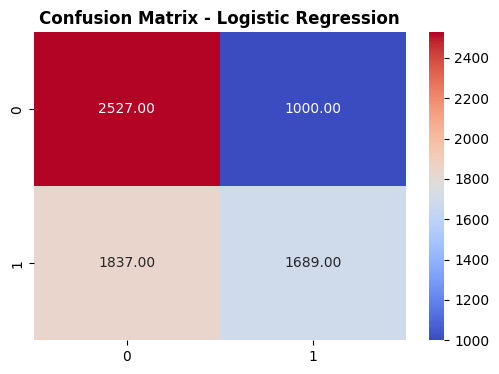

In [ ]:
model = LogisticRegression(max_iter=5000, random_state=42)
model.fit(x_train_scaled, y_train)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

y_pred = model.predict(x_test_scaled)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'Report:\n{report}\n')

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix - Logistic Regression', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

Cross Validation Scores: [0.607  0.6014 0.5894 0.6098 0.599 ]
Mean of Cross Validation Scores: 0.60132



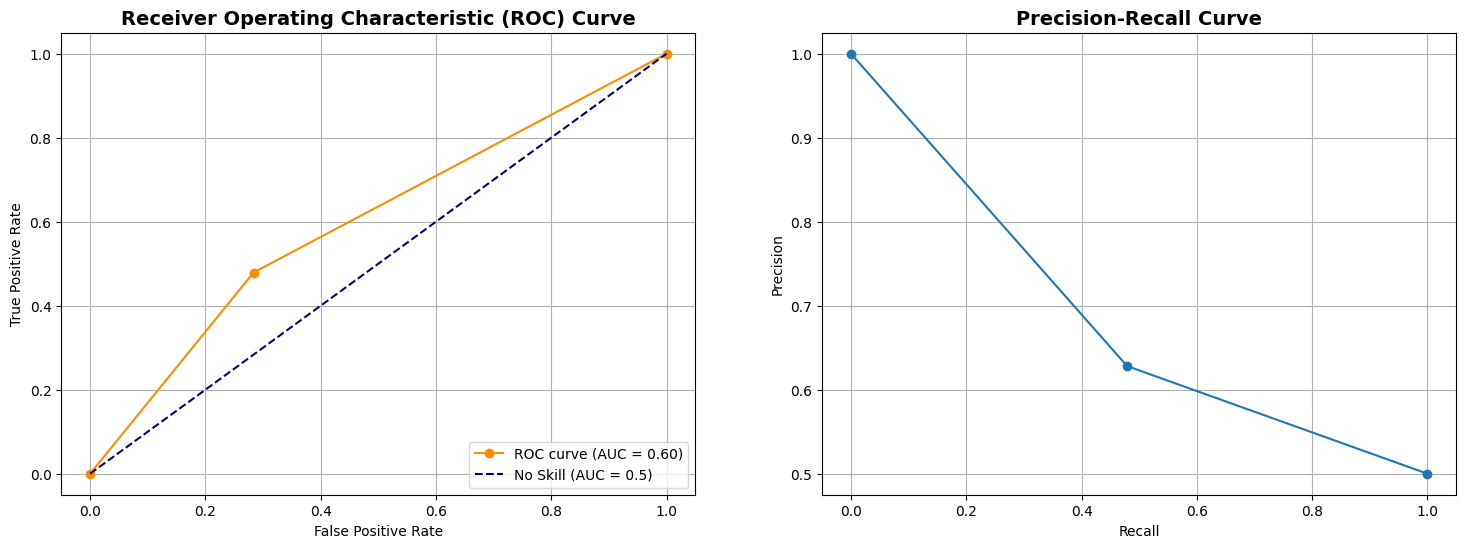

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', marker='o', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()

##**2. Support Vector Classifier - SVC**
---

Cross Validation Scores: [0.6082 0.6076 0.6024 0.6076 0.6064]
Mean of Cross Validation Scores: 0.6064400000000001

Report:
              precision    recall  f1-score   support

           0       0.59      0.64      0.62      3527
           1       0.61      0.56      0.58      3526

    accuracy                           0.60      7053
   macro avg       0.60      0.60      0.60      7053
weighted avg       0.60      0.60      0.60      7053




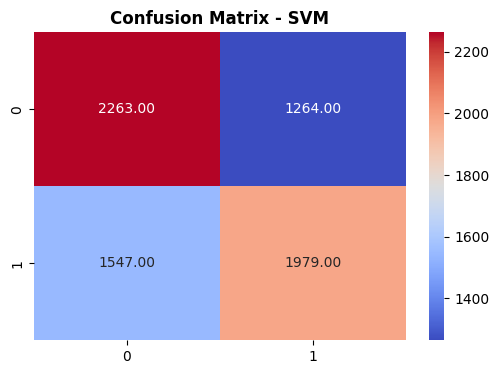

In [ ]:
model = SVC(kernel='rbf')
model.fit(x_train_scaled, y_train)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

y_pred = model.predict(x_test_scaled)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'Report:\n{report}\n')

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix - SVM', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

Cross Validation Scores: [0.6082 0.6076 0.6024 0.6076 0.6064]
Mean of Cross Validation Scores: 0.6064400000000001



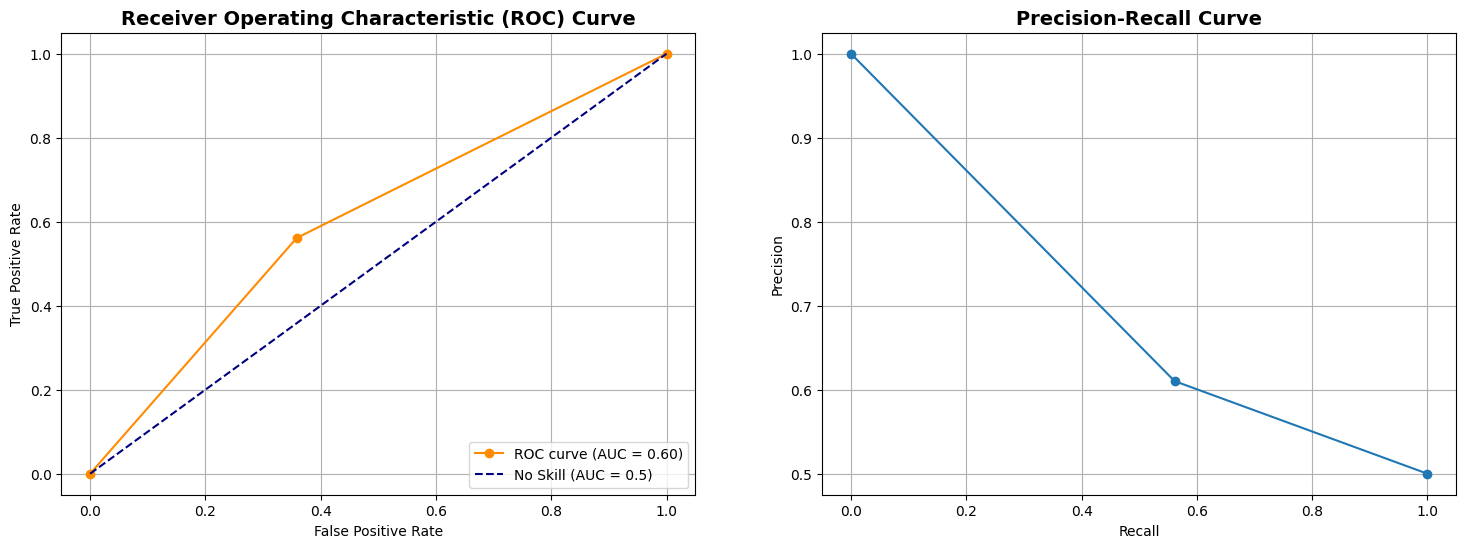

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', marker='o', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()

##**3. Random Forest Classifier**
---

Cross Validation Scores: [0.6074 0.6116 0.5988 0.6024 0.605 ]
Mean of Cross Validation Scores: 0.60504

Report:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62      3527
           1       0.61      0.54      0.57      3526

    accuracy                           0.60      7053
   macro avg       0.60      0.60      0.60      7053
weighted avg       0.60      0.60      0.60      7053




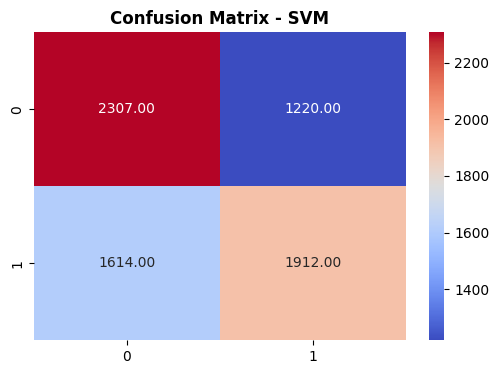

In [ ]:
model = RandomForestClassifier()
model.fit(x_train_scaled, y_train)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

y_pred = model.predict(x_test_scaled)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'Report:\n{report}\n')

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix - SVM', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

Cross Validation Scores: [0.608  0.6096 0.6014 0.6008 0.6052]
Mean of Cross Validation Scores: 0.605



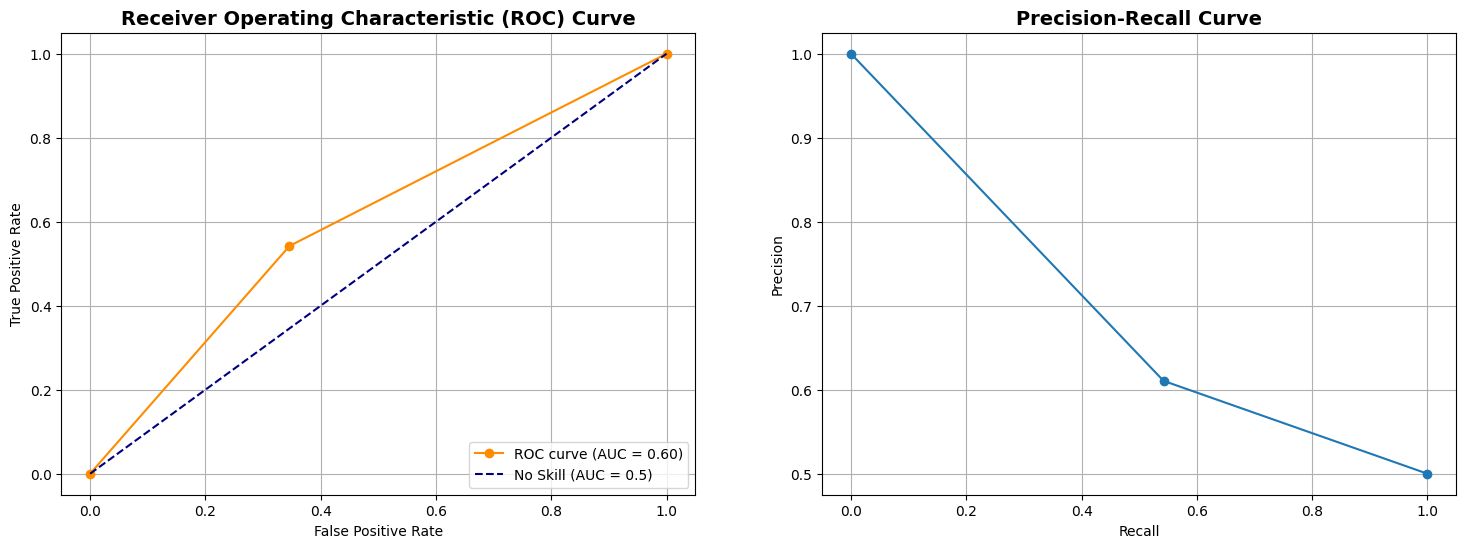

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', marker='o', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()

##**4. Data Clustering**
---

###a. Feature Selection

####a.1. Permutation Importance

In [ ]:
df_fs = df_new.copy()
df_fs = df_fs[cols_rfecv]

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_fs)
label = kmeans.labels_

selector_permutation = permutation_importance(kmeans, df_fs, label, n_repeats=100, random_state=42)
result = pd.DataFrame({
    'importance': selector_permutation['importances_mean'].tolist()
}, index=df_fs.columns.tolist()).sort_values(by='importance', ascending=False)
result

,importance
n_inpatient,5155.614596
n_outpatient,3652.137356
n_procedures,2469.672800
n_emergency,1838.565539
age,640.200766
diag_2_Other,142.731210
diag_1_Other,131.053074
diag_1_Respiratory,77.907165
diag_3_Other,72.296144
diag_2_Diabetes,18.864144


In [ ]:
cols_perm_imp = [val for val in result.head(4).index.tolist()]

####a.2. Select K-Best - using clustering metrics

In [ ]:
df_kbest = df_new.copy()
df_kbest = df_kbest[cols_rfecv]

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_kbest)
label = kmeans.labels_

selector_kbest = SelectKBest(score_func=chi2, k=5)
selector_kbest.fit(df_kbest, label)

score_df = pd.DataFrame({
    'score': selector_kbest.scores_
}, index=df_kbest.columns.tolist()).sort_values(by='score', ascending=False)
score_df

,score
n_procedures,39652.440467
n_inpatient,24861.638288
n_outpatient,21448.382129
n_emergency,7108.781241
diag_1_Respiratory,265.022896
diag_1_Other,248.886420
diag_2_Other,194.671270
age,140.530798
diag_2_Injury,105.729311
diag_3_Other,97.600079


In [ ]:
cols_skbest_cl = [col for col in score_df.head(4).index.tolist()]

####a.3. Select K-Best - using previous parameters

In [ ]:
df_kbest = df_new.copy()
df_kbest = df_kbest[cols_rfecv]
y = df_new['readmitted']

selector_kbest = SelectKBest(score_func=chi2, k=5)
selector_kbest.fit(df_kbest, y)

score_df = pd.DataFrame({
    'score': selector_kbest.scores_
}, index=df_kbest.columns.tolist()).sort_values(by='score', ascending=False)
score_df

,score
n_inpatient,2542.510429
n_emergency,919.496308
n_outpatient,889.074252
n_procedures,107.528137
diag_1_Diabetes,30.722838
diag_1_Musculoskeletal,28.114543
change,25.205415
diabetes_med,22.291670
age,16.934625
A1Ctest_normal,11.955558


In [ ]:
cols_skbest_reg = [col for col in score_df.head(3).index.tolist()]

###b. Clustering

In [ ]:
columns = {
    'permutation_importance': cols_perm_imp,
    'selectkbest_cluster_metrics': cols_skbest_cl,
    'selectkbest_regular_metrics': cols_skbest_reg
  }

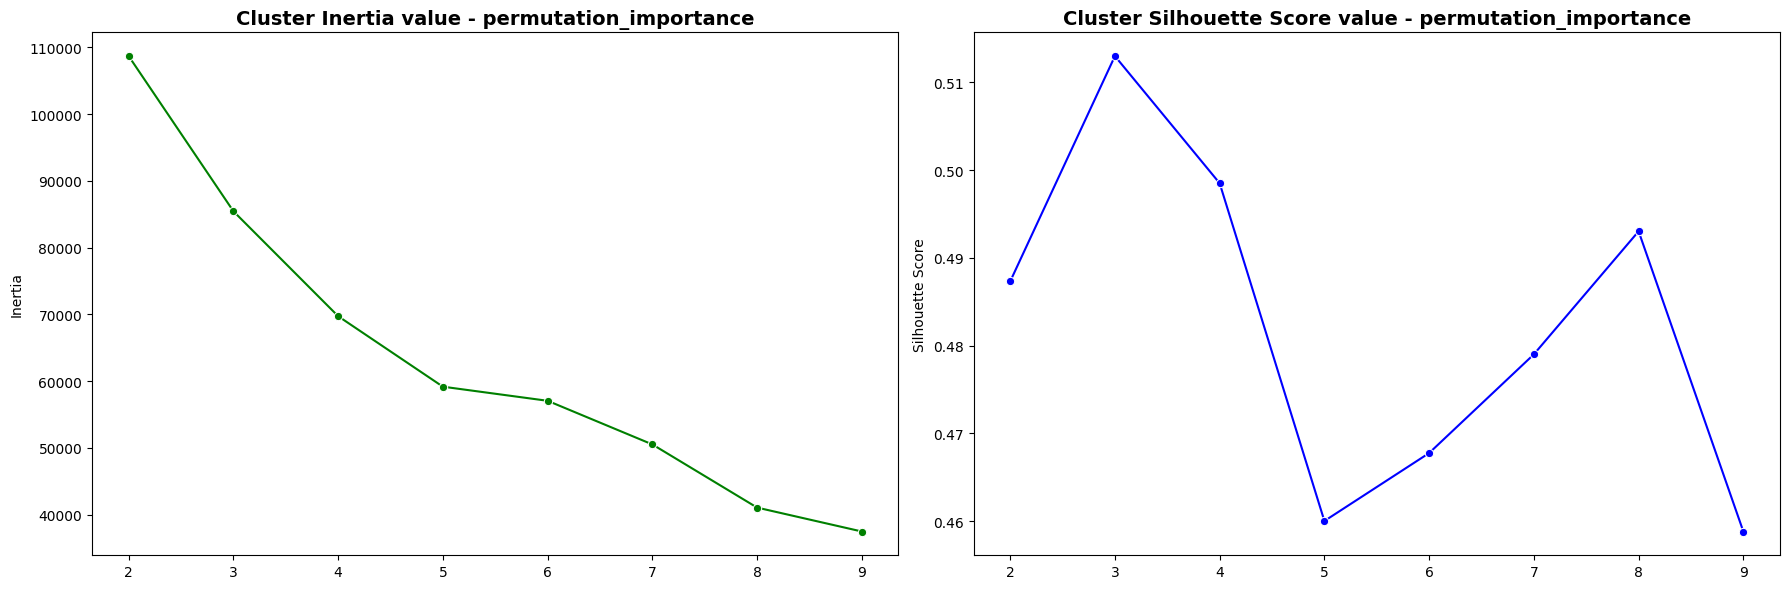

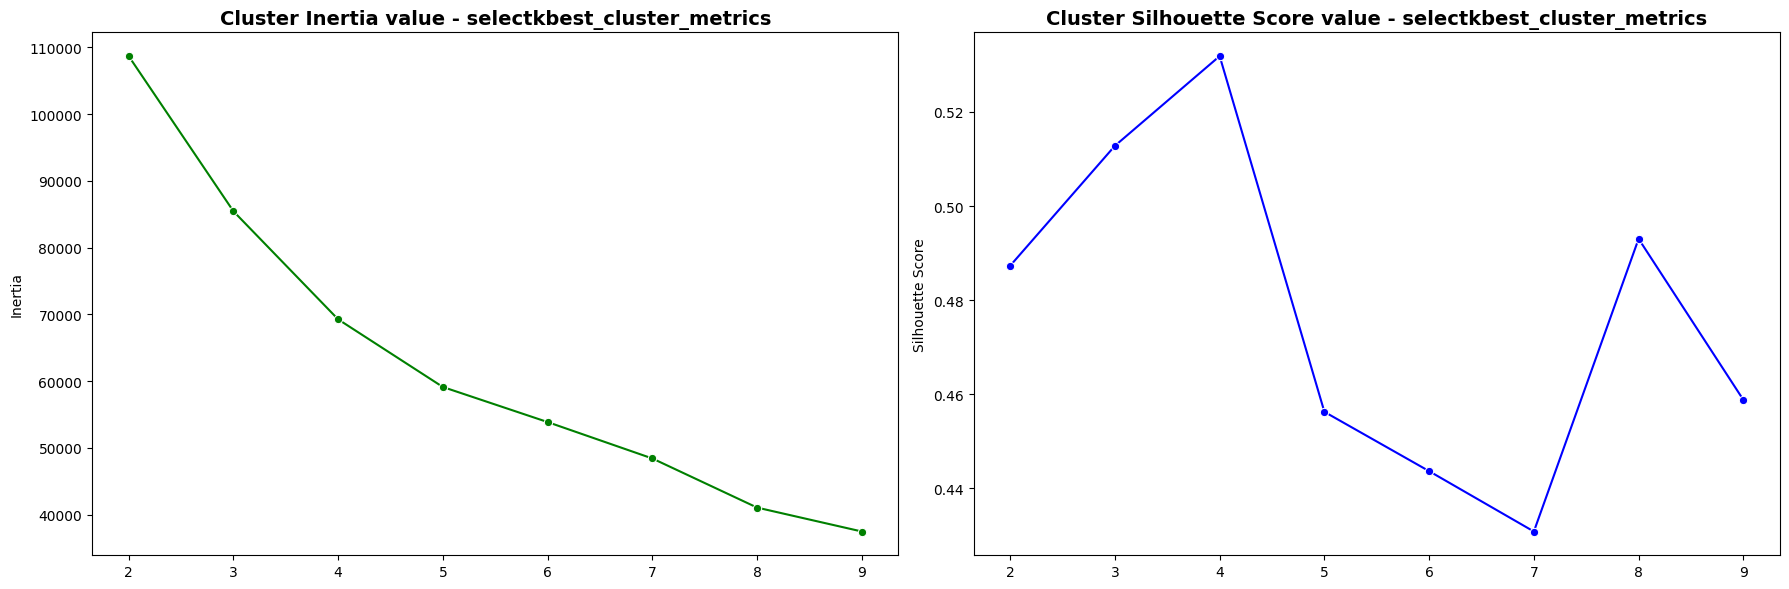

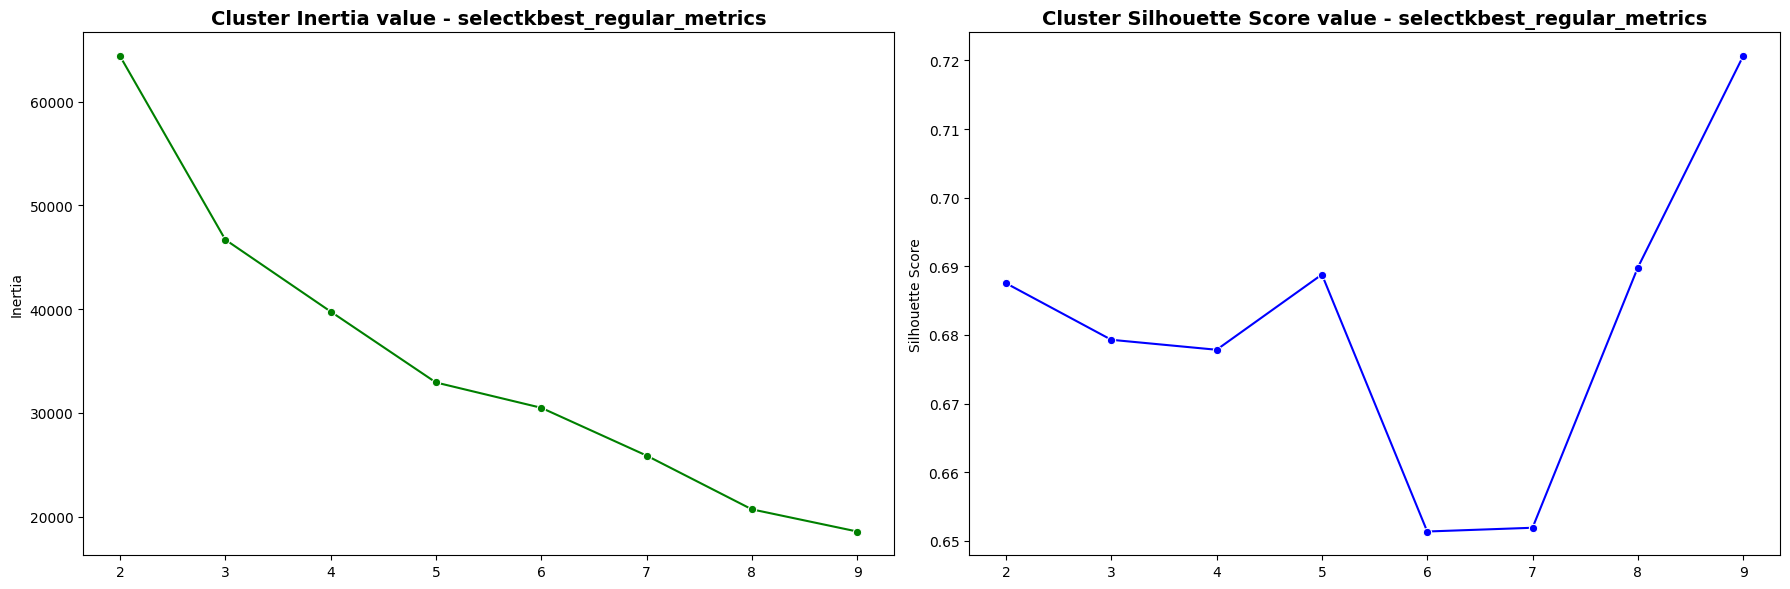

In [ ]:
for column_to_use in columns:
  inertia, sil_score = [], []
  color = ['green', 'blue']
  n_clusters_range = range(2, 10)
  df_cl = df[columns[column_to_use]]

  for cluster in n_clusters_range:
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    kmeans.fit(df_cl)
    label = kmeans.labels_
    sil_score.append(silhouette_score(df_cl, label, metric='euclidean'))
    inertia.append(kmeans.inertia_)

  result = pd.DataFrame({
      'Inertia': inertia,
      'Silhouette Score': sil_score
  }, index=n_clusters_range)

  plt.figure(figsize=(18, 6))
  for i, col in enumerate(result.columns):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x=result.index.tolist(), y=result[col], marker='o', color=color[i])
    plt.title(f'Cluster {col} value - {column_to_use}', fontsize=14, fontweight='bold')
  plt.tight_layout()
  plt.show()
  print(' ')

In [ ]:
df_cl = df[cols_skbest_reg]

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_cl)
label = kmeans.labels_

df['cluster'] = kmeans.fit_predict(df[cols_skbest_reg])
df_cl['cluster'] = kmeans.fit_predict(df_cl)
sil = silhouette_score(df_cl, label, metric='euclidean')
print(f'Silhouette Score: {sil}')

/tmp/ipython-input-2154079035.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['cluster'] = kmeans.fit_predict(df_cl)


Silhouette Score: 0.7666462317136161


####b.1. Clustering Results

In [ ]:
cl_result = df_cl.groupby(by='cluster').agg({
    'n_inpatient': 'mean',
    'n_emergency': 'mean',
    'n_outpatient':'mean'
})
cl_result

,n_inpatient,n_emergency,n_outpatient
cluster,,,
0,0.220642,0.094819,0.077986
1,1.404412,0.419118,10.639706
2,2.971223,0.334205,0.283519
3,3.203390,6.796610,0.960452
4,0.673611,0.287037,2.965278


In [ ]:
df['cluster'].value_counts()

,count
cluster,
0,19901
2,3058
4,1728
3,177
1,136


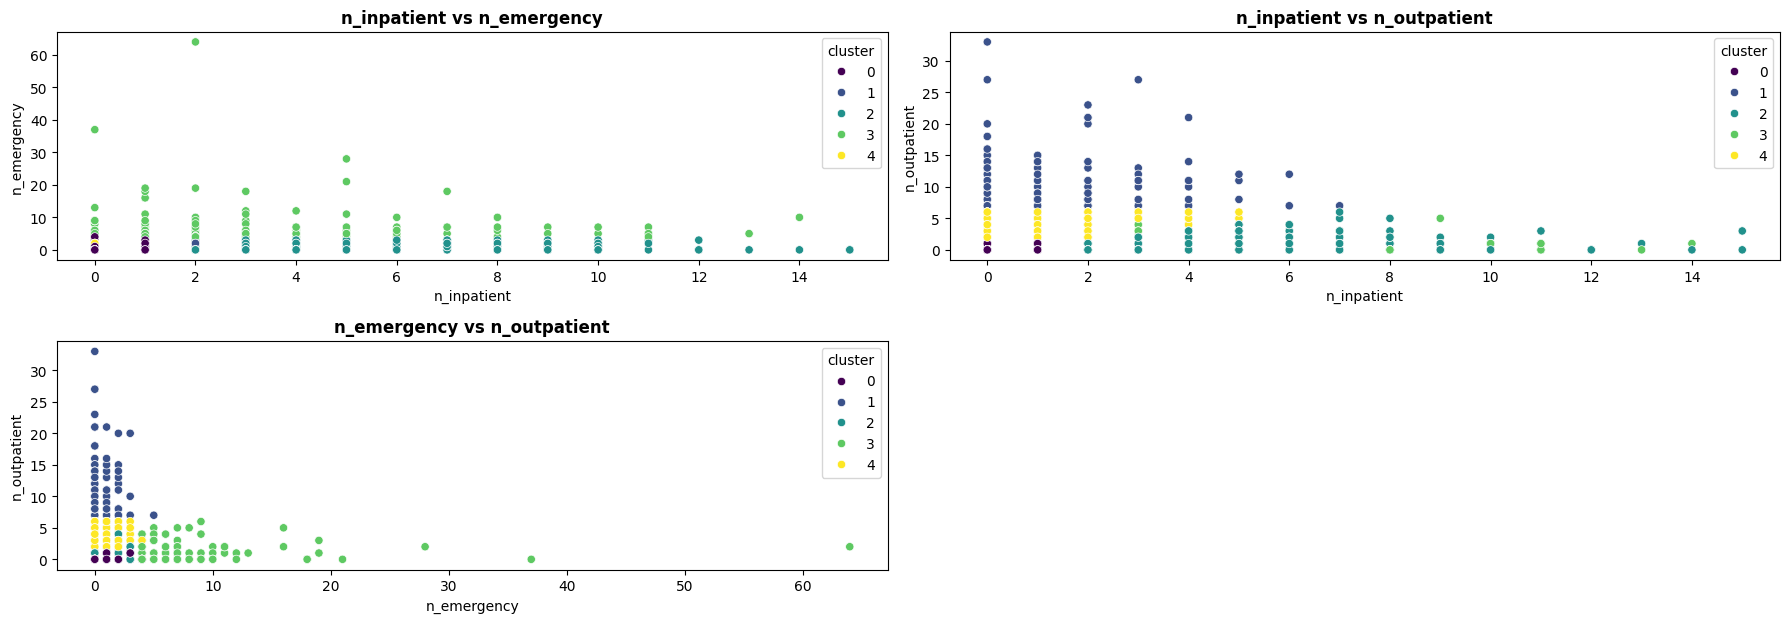

In [ ]:
cols_used = []
cols_to_use = [col for col in df_cl.columns if col != 'cluster']
i = 0

plt.figure(figsize=(18, 9))
for col in cols_to_use:
  cols_used.append(col)
  columns = [column for column in cols_to_use if column not in cols_used]
  for column in columns:
    plt.subplot(3, 2, i+1)
    sns.scatterplot(x=df_cl[col], y=df_cl[column], hue=df_cl['cluster'], palette='viridis')
    plt.title(f'{col} vs {column}', fontsize=12, fontweight='bold')
    i+=1
plt.tight_layout()
plt.show()

####b.2. Categorical Data Distribution on Each Clusters

In [ ]:
df_cluster_0 = df[df['cluster'] == 0]
df_cluster_1 = df[df['cluster'] == 1]
df_cluster_2 = df[df['cluster'] == 2]
df_cluster_3 = df[df['cluster'] == 3]
df_cluster_4 = df[df['cluster'] == 4]

clusters_data = [df_cluster_0, df_cluster_1, df_cluster_2, df_cluster_3, df_cluster_4]

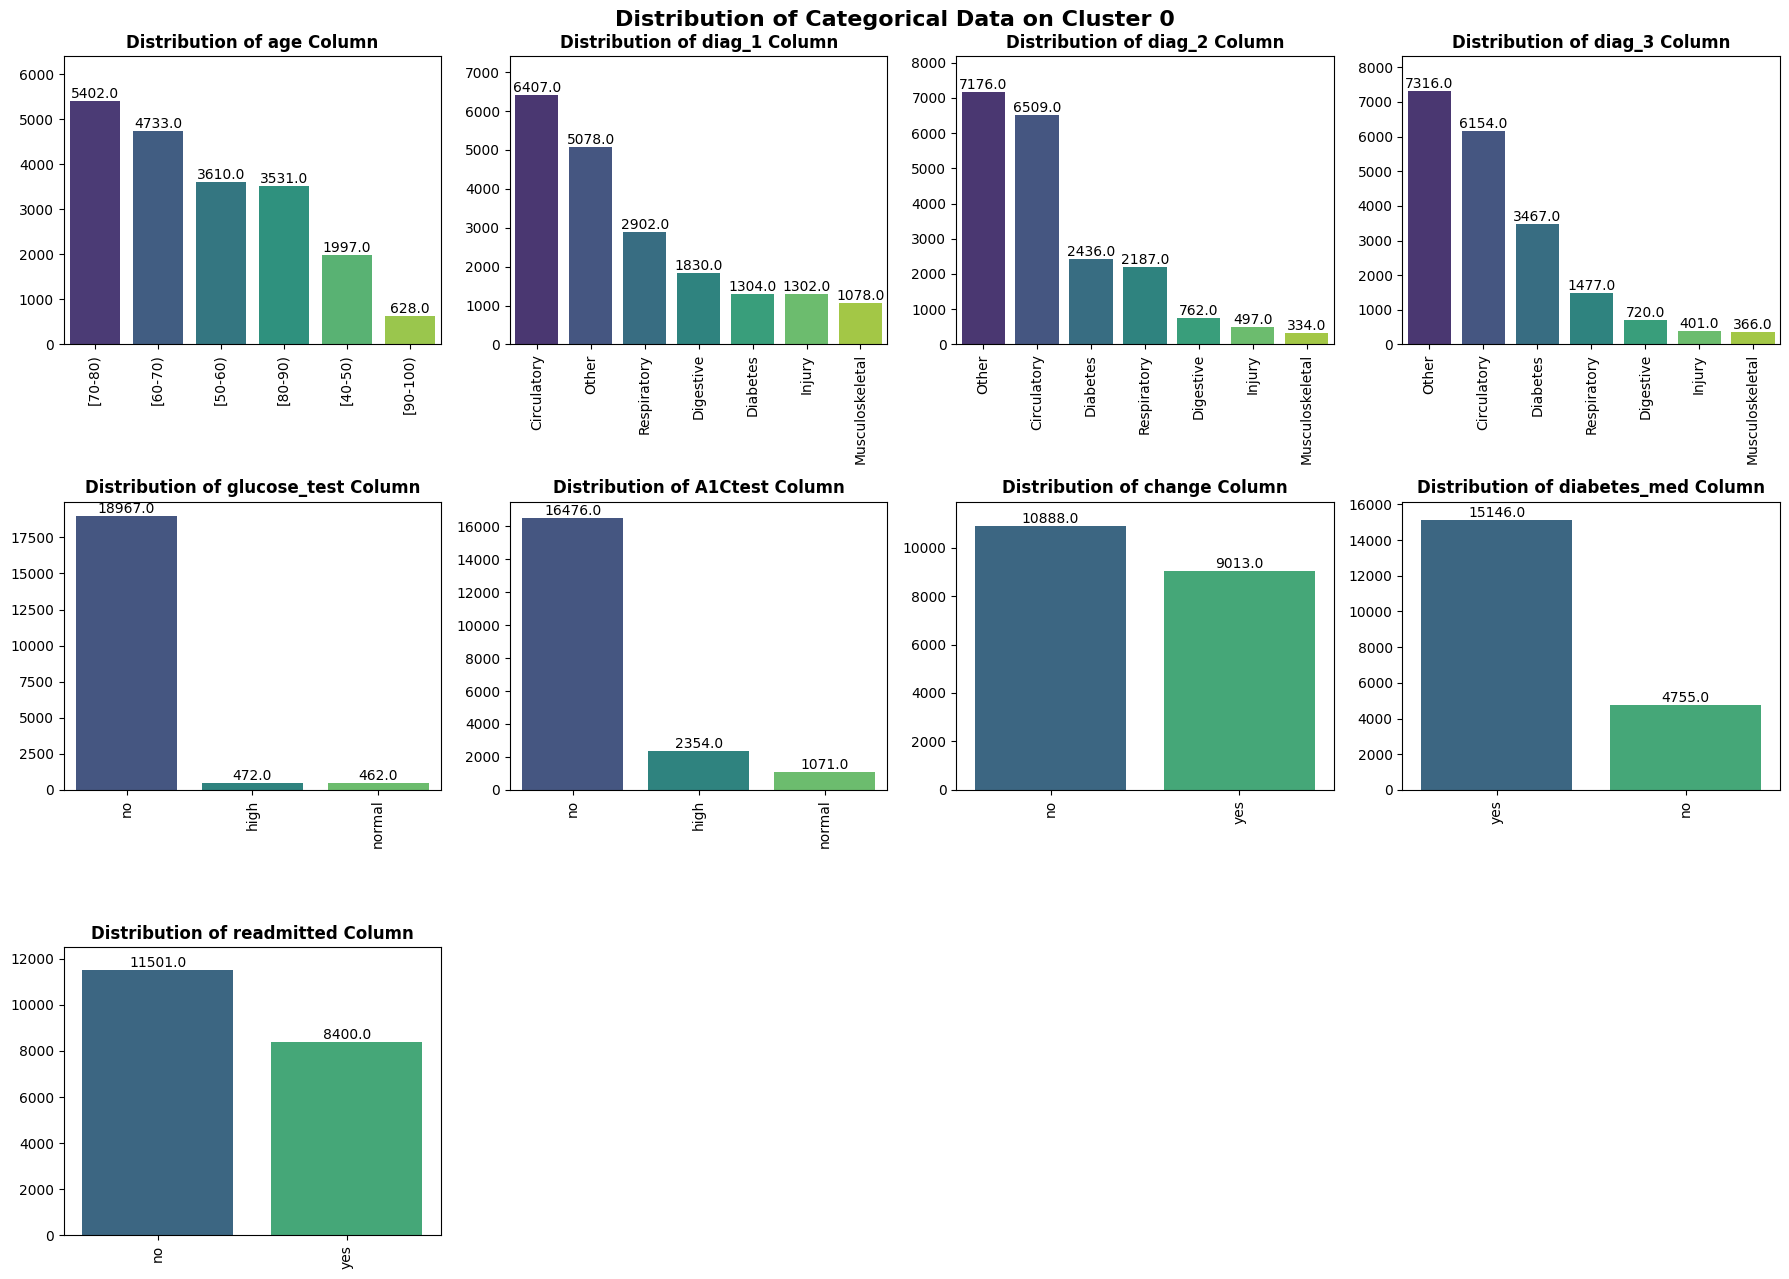

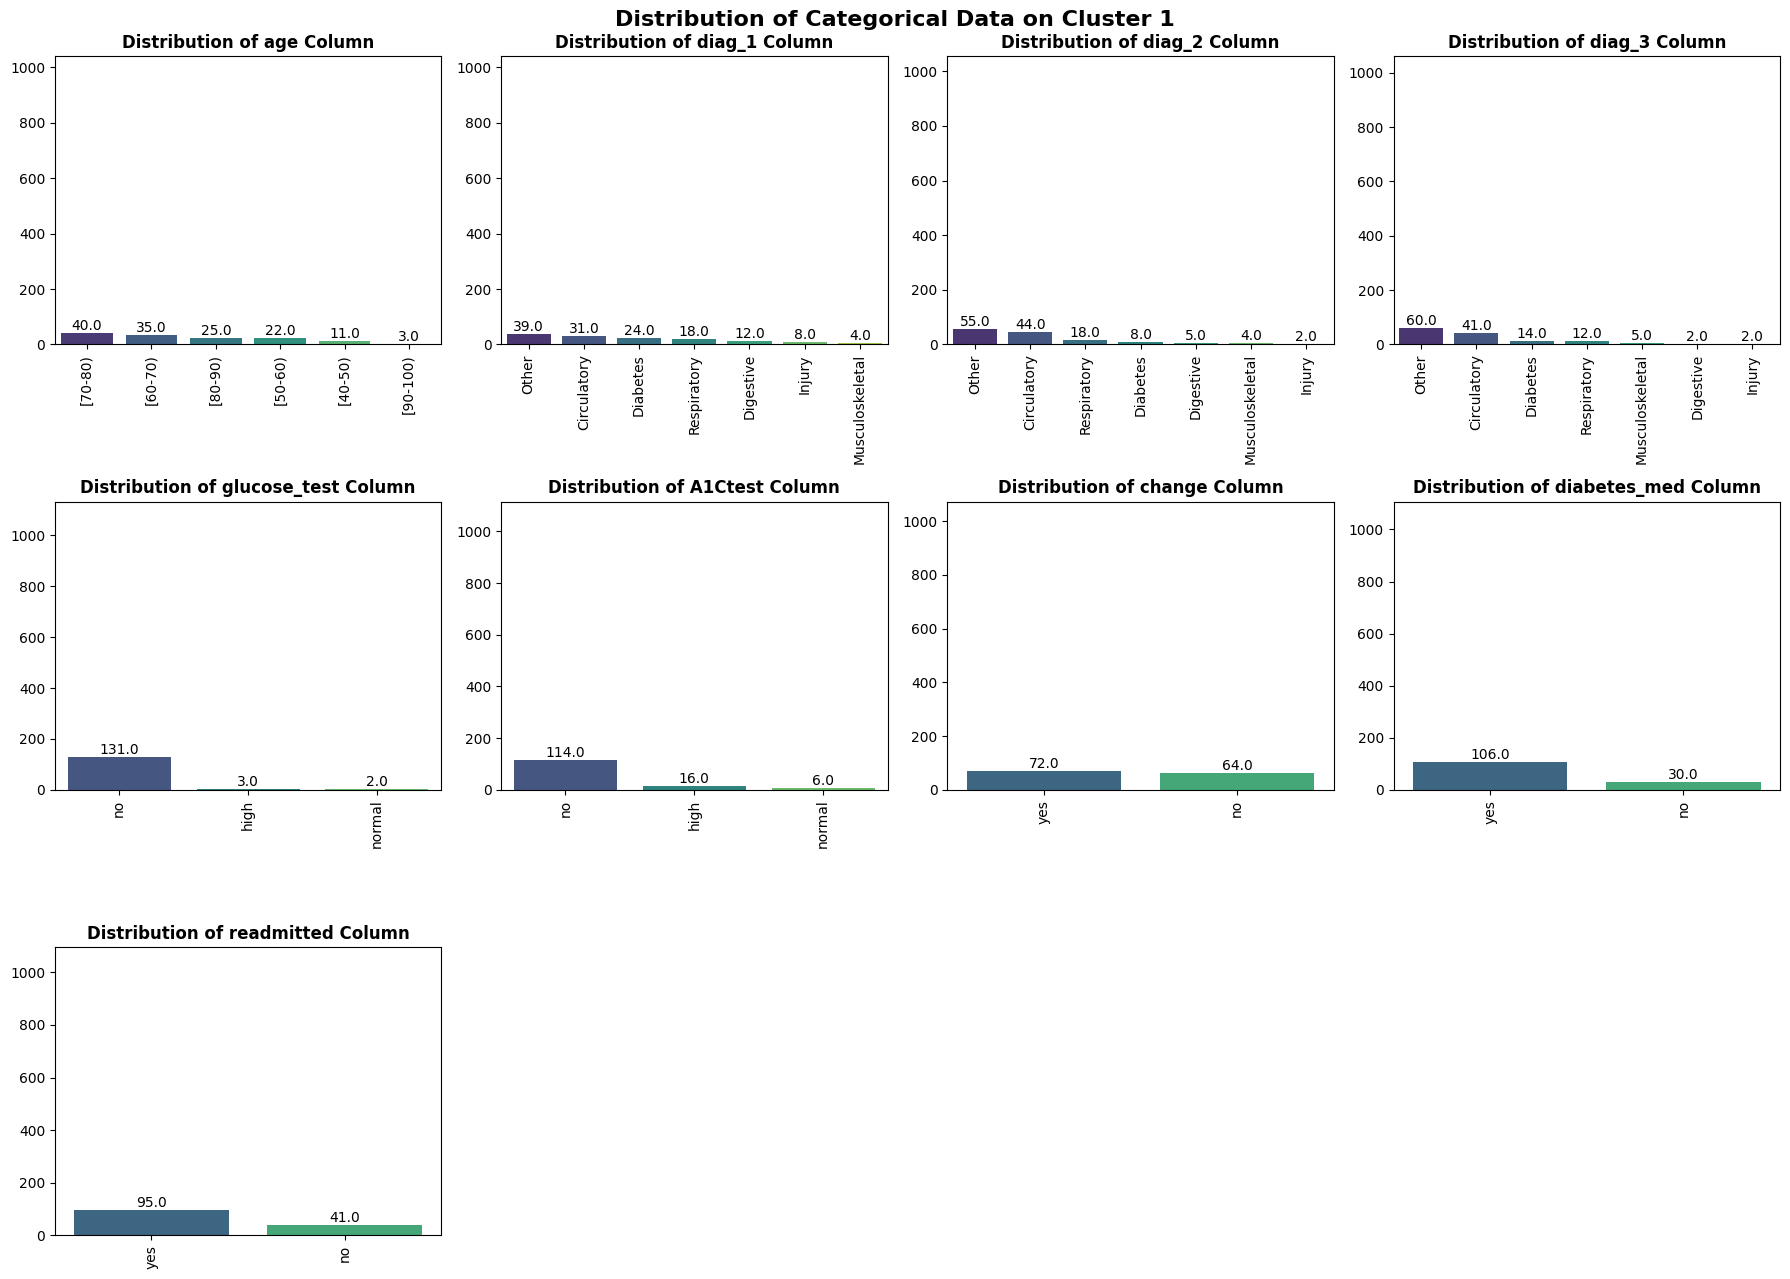

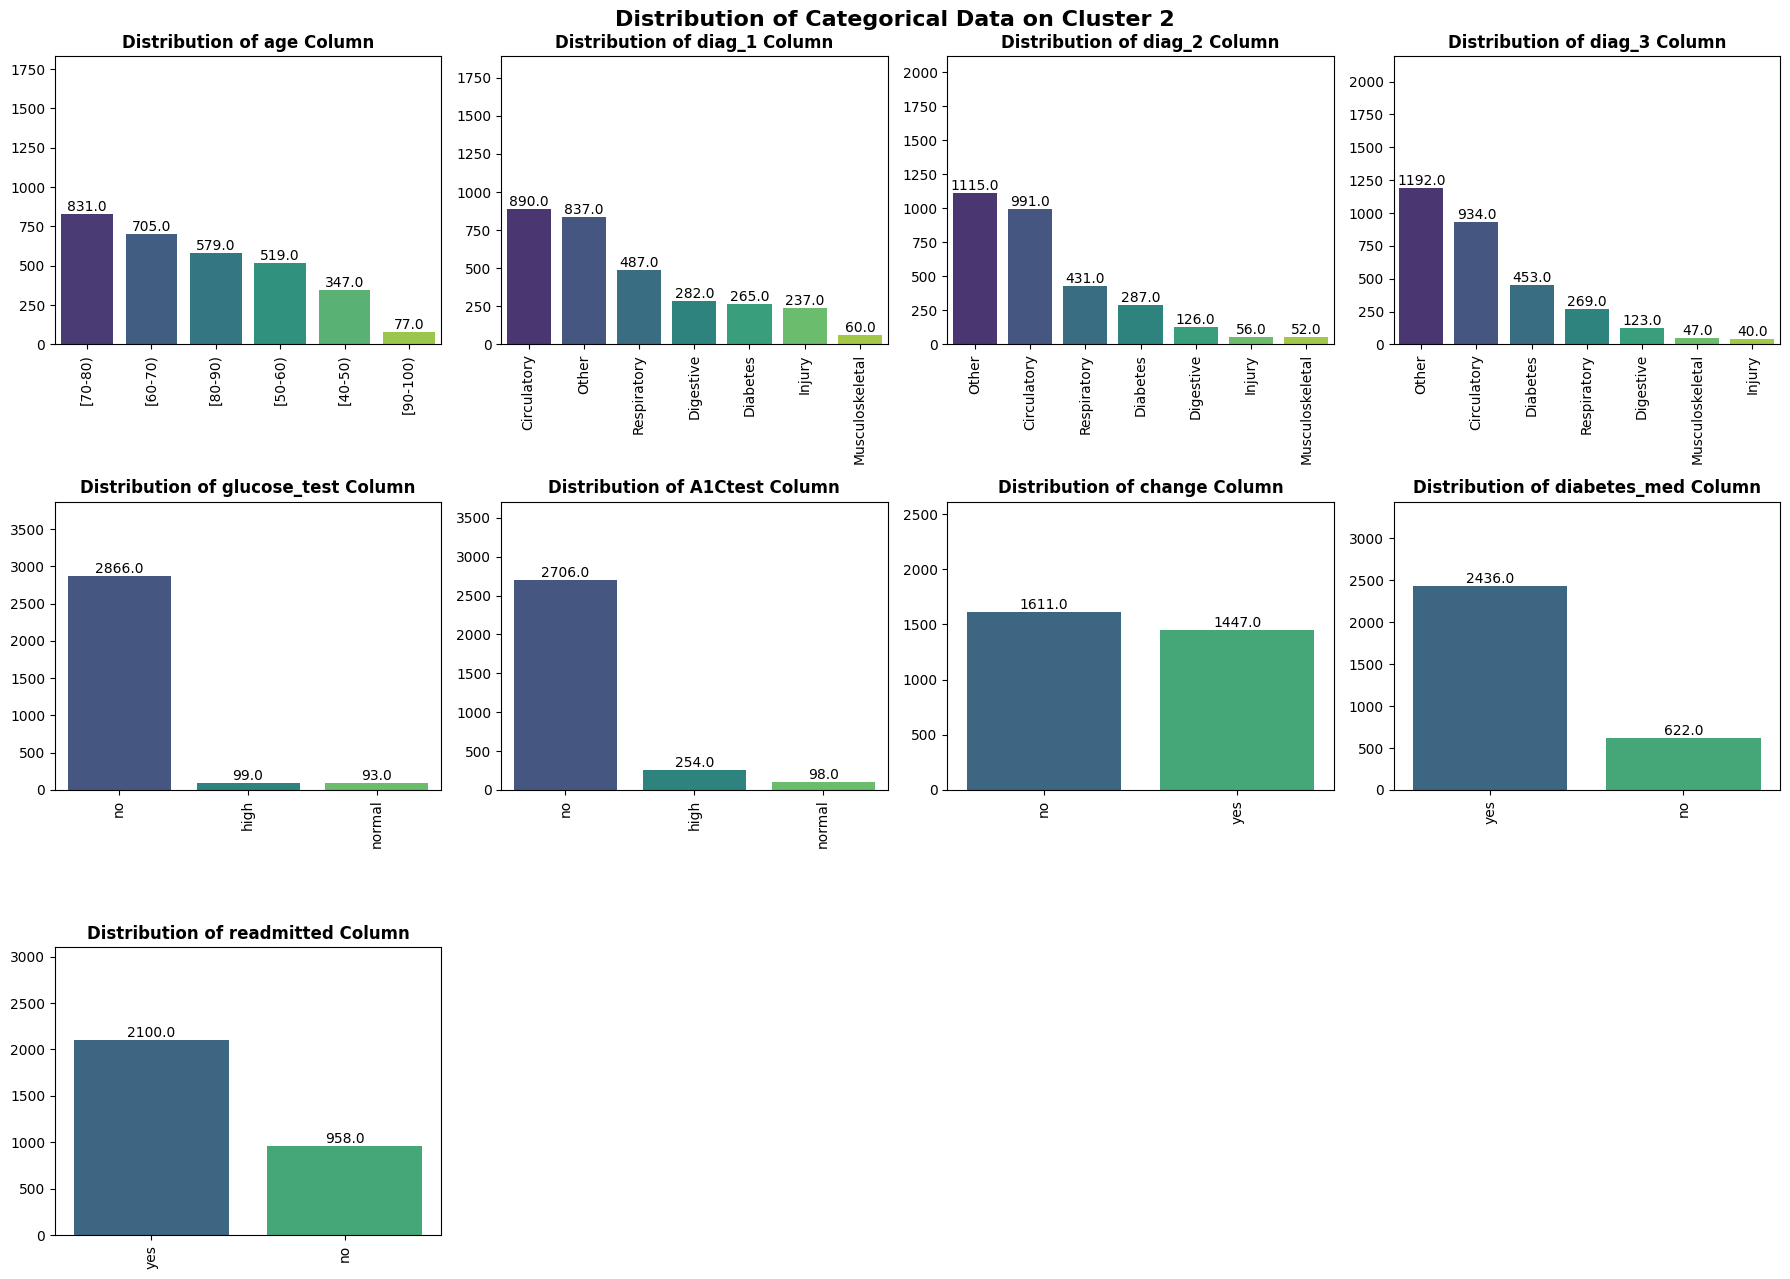

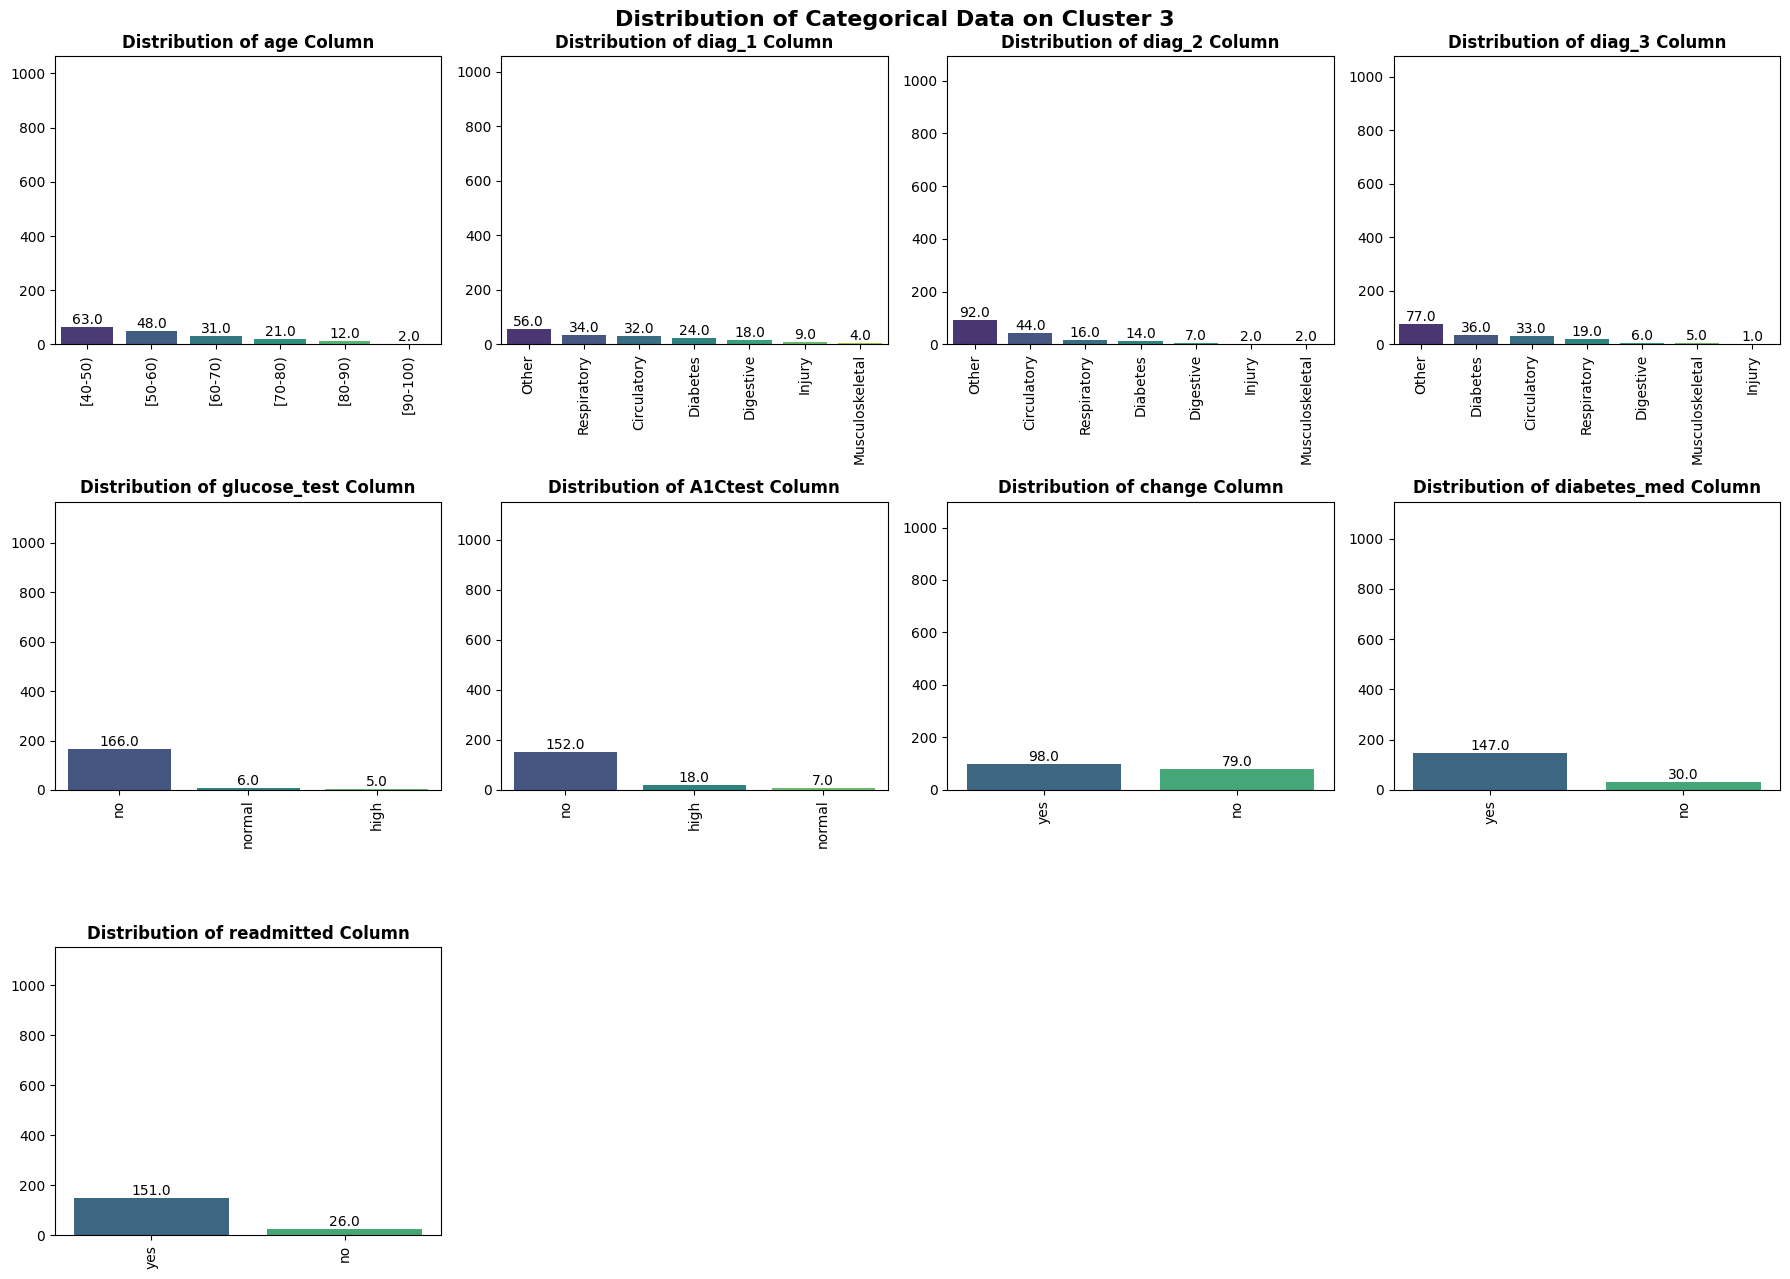

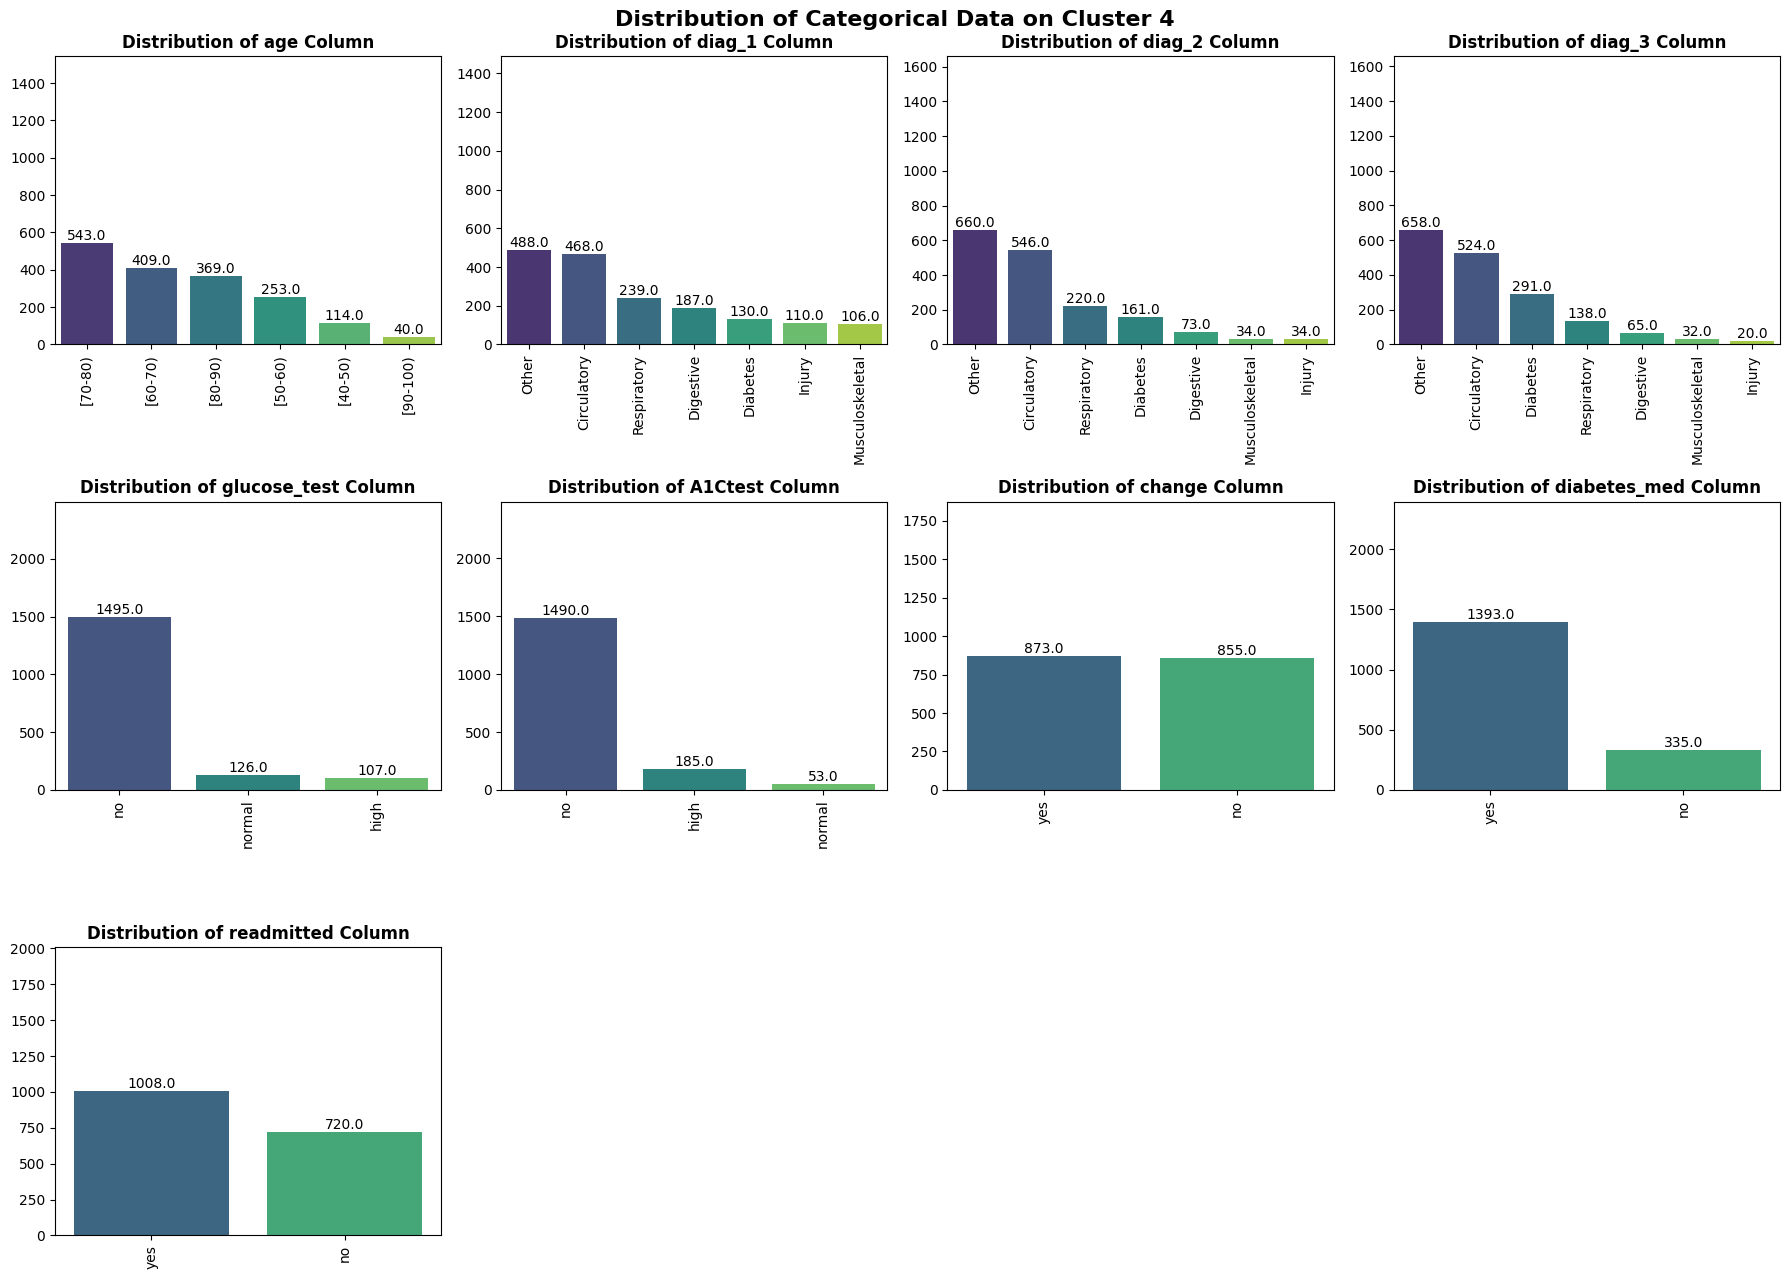

In [ ]:
cluster = 0
for data in clusters_data:
  df_cat = data.select_dtypes(include='object')

  plt.figure(figsize=(18, 13))
  for i, col in enumerate(df_cat.columns):
    plt.subplot(3, 4, i+1)
    counts = df_cat[col].value_counts()
    ax = sns.barplot(x=counts.index.tolist(), y=counts.values.tolist(), hue=df_cat[col].unique().tolist(), legend=False, palette='viridis')
    plt.title(f'Distribution of {col} Column', fontsize=12, fontweight='bold')
    for val in ax.containers:
      label=[v.get_height() for v in val]
      ax.bar_label(val, labels=label, label_type='edge')
    plt.ylim(ymax=counts.max() + 1000)
    plt.xticks(rotation=90)
  plt.suptitle(f'Distribution of Categorical Data on Cluster {cluster}', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()
  print(' ')
  cluster+=1

#**Conclusion**
---
The resulting model that was created using Random Forest, Support Vector, and Logistic Regression classifiers have yielded all relatively similar results. The resulting accuracy are all 60%, whilst scores such as Recall, Precision, and F1-Score are still averaged at around 60%. This shows that the model could still be improved, by adding more data or using different preprocessing methods as have been used in this project. However, it should be noted that the cause for this performance may have been due to the equal distribution of diagnosis, age, and tests across readmitted and not readmitted patients.

On the other hand, the results of clustering are satisfactory, and it brings in interesting insights regarding patient segmentation:
1. **Cluster 0**: Patients in this cluster **has low numbers of inpatient, oupatient, and emergency visits**. Here, most patients are **not readmitted**, but when admitted, many are **experiencing circulatory, respiratory, or diabetic problems** and many would **need blood change and diabetes medication**. This shows that **patients of this cluster does not require intensive care and does not visit often (despite having fairly serious illnesses), and as such, are of the lowest concern**.
2. **Cluster 1**: This cluster includes patients who **has high numbers of outpatient visits and medium numbers of inpatient visits**, but **low numbers of emergency visits**. Many patients of this cluster are **taking diabetes medication**. Also, **around 2/3 patients of this cluster are readmitted**. This suggests that patients of this cluster ***are experiencing illnesses that require frequent hospital visits, but does not require intensive care***.
3. **Cluster 2**: Patients of this cluster has **high numbers of inpatient visits**, but **low numbers of outpatient and emergency visits**. Also, unlinke other clusters, where patients are old, **a significant percentage of patients of this clutser are younger (40-50 years old)**. At the same time, much of the patients **are taking diabetic medications, having circulatory problems, require blood change, and are readmitted**. This suggests that patients of this cluster, whilst not requiring emergency visits, ***are experiencing severe illness and requires intensive care, but their illness does not worsen suddenly, akin to a long-term illness***.
4. **Cluster 3**: Includes patients with **high numbers of emergency and inpatient visits**, meaning that patients of this cluster has had severe illnesses and has had to stay for some time at the hospital for such illnesses. At the same time, **most** patients of this cluster **are on diabetes medication and are readmitted patients**. As such, ***patients of this cluster are of highest concern since they require intensive care and their illness can worsen suddenly***.
5. **Cluster 4**: In this cluster, patients **has medium numbers of inpatient visits**, but **low numbers of outpatient and emergency visits**. Many of the patients of this cluster are **experiencing circulatory issues, requires blood change,** and **are on diabetic medication**. Lastly, **many patients of this cluster are readmitted**. It could be concluded that patients of this cluster ***are coming to the hospital mostly due to severe, but not critical, illnesses (likely because patients of this cluster have just been diagnosed or are in an early stage of severe illness)***.

Based on this result, it could be said that patients in cluster 3 are the most high-risk, followed by patients of cluster 2. Patients of this cluster should be given extra care given their risk and illness. Patients of cluster 4 also should be watched closely, as their illness may become or is already critical, since many of them require extensive care. Patients of cluster 1 should also be watched closely, as they visit the hospital often (despite the visits being due to minor illnesses), which may be symptomps of an underlying, severe illness.

Only patients of cluster 0 which would not require any extensive care, and as such, should be of the lowest concern for the hospital